In [1]:
import numpy as np
import scipy.signal
from math import log10, floor
from tqdm import tqdm
import shutil
from bisect import bisect_left
from random import sample
import re

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
plt.style.use('Software/stefan.mplstyle')

import pandas as pd
pd.set_option('display.max_columns', None)
# Suppress SettingWithCopyWarnings
pd.options.mode.chained_assignment = None  # default='warn'

from astropy.coordinates import SkyCoord
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
import astropy.units as u


In [2]:
#use wd_models environment to measure Moran's I from data

#import WD models
import sys
import os
sys.path.append('Software')
import WD_models

In [3]:
#use wdtools_env_pip environment to apply CNN to measured Moran's I

#for machine learning
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# This notebook measures the Moran's I and Z-Score curves as a function of distance for real data

In [3]:
#import the VAC catalog measurements with quality cuts
wd_table=pd.read_csv('csv/wd_table.csv')

#also import the version with no extinction corrections
wd_table_noext=pd.read_csv('csv/wd_table_noext.csv')

/var/folders/ny/bjybyvhj6s9_2ms5cmld1xbc0000gn/T/ipykernel_85184/4036453149.py:2: DtypeWarning: Columns (18,25,77,88,100,109,114,126,127,292) have mixed types. Specify dtype option on import or set low_memory=False.
  wd_table=pd.read_csv('csv/wd_table.csv')
/var/folders/ny/bjybyvhj6s9_2ms5cmld1xbc0000gn/T/ipykernel_85184/4036453149.py:5: DtypeWarning: Columns (18,25,77,88,100,109,114,126,127,292) have mixed types. Specify dtype option on import or set low_memory=False.
  wd_table_noext=pd.read_csv('csv/wd_table_noext.csv')


In [4]:
reformat_wdtable=pd.DataFrame()
reformat_wdtable['teff_measured']=wd_table['teff_phot'] 
reformat_wdtable['radius_measured']=wd_table['radius_phot']
reformat_wdtable['logg_measured']=wd_table['logg_prf_coadd']
reformat_wdtable['mass_measured']=wd_table['mass_rad_logg'] #must use mass where combine measured radius with measured logg so don't have assumed M-R relation
reformat_wdtable['distance_measured']=wd_table['r_med_geo']
reformat_wdtable['l_measured']=wd_table['l']
reformat_wdtable['b_measured']=wd_table['b']

#convert l, b, and distance (which are in galactic coordinates) to a cartesian representation
coords_cartesian=SkyCoord(l=np.array(reformat_wdtable['l_measured'].to_list())*u.deg, 
                          b=np.array(reformat_wdtable['b_measured'].to_list())*u.deg, 
                          distance=np.array(reformat_wdtable['distance_measured'].to_list())*u.pc,
                          frame='galactic')
coords_cartesian.representation_type = 'cartesian'
u_sample=coords_cartesian.u.value
v_sample=coords_cartesian.v.value
w_sample=coords_cartesian.w.value

reformat_wdtable['u_measured']=u_sample
reformat_wdtable['v_measured']=v_sample
reformat_wdtable['w_measured']=w_sample

display(reformat_wdtable)

,teff_measured,radius_measured,logg_measured,mass_measured,distance_measured,l_measured,b_measured,u_measured,v_measured,w_measured
0,6216.240027,0.008811,7.862471,0.202929,67.303879,176.115112,-48.741898,-44.281701,3.007090,-50.595459
1,14397.339856,0.014460,8.014554,0.781794,224.510941,176.967087,-47.621120,-151.115176,8.006659,-165.847097
2,12415.216971,0.013135,8.030271,0.661785,153.012146,175.361862,-48.867638,-100.321902,8.138922,-115.247519
3,18476.387797,0.018948,7.890760,1.017269,584.368469,160.672760,6.230750,-548.178222,192.261912,63.423195
4,6667.572953,0.008918,7.865920,0.212818,91.554710,160.316818,5.723994,-85.775290,30.683598,9.131341
...,...,...,...,...,...,...,...,...,...,...
10202,23142.645123,0.016043,8.016200,0.973512,504.335940,43.869011,-31.879321,308.746019,296.791465,-266.355894
10203,13429.441119,0.013679,8.182480,1.037843,371.764040,40.623984,-28.347188,248.332689,213.027242,-176.518472
10204,7976.558139,0.018768,7.966760,1.188863,198.573780,41.496140,-28.147176,131.142620,116.009439,-93.674807
10205,14067.570209,0.013964,8.129640,0.957645,279.956670,41.508007,-27.476908,186.000134,164.605360,-129.169512


In [5]:
reformat_wdtable_noext=pd.DataFrame()
reformat_wdtable_noext['teff_measured']=wd_table_noext['teff_phot_noext'] 
reformat_wdtable_noext['radius_measured']=wd_table_noext['radius_phot_noext']
reformat_wdtable_noext['logg_measured']=wd_table_noext['logg_prf_coadd']
reformat_wdtable_noext['mass_measured']=wd_table_noext['mass_rad_logg_noext'] #must use mass where combine measured radius with measured logg so don't have assumed M-R relation
reformat_wdtable_noext['distance_measured']=wd_table_noext['r_med_geo']
reformat_wdtable_noext['l_measured']=wd_table_noext['l']
reformat_wdtable_noext['b_measured']=wd_table_noext['b']

#convert l, b, and distance (which are in galactic coordinates) to a cartesian representation
coords_cartesian=SkyCoord(l=np.array(reformat_wdtable_noext['l_measured'].to_list())*u.deg, 
                          b=np.array(reformat_wdtable_noext['b_measured'].to_list())*u.deg, 
                          distance=np.array(reformat_wdtable_noext['distance_measured'].to_list())*u.pc,
                          frame='galactic')
coords_cartesian.representation_type = 'cartesian'
u_sample=coords_cartesian.u.value
v_sample=coords_cartesian.v.value
w_sample=coords_cartesian.w.value

reformat_wdtable_noext['u_measured']=u_sample
reformat_wdtable_noext['v_measured']=v_sample
reformat_wdtable_noext['w_measured']=w_sample

display(reformat_wdtable_noext)

,teff_measured,radius_measured,logg_measured,mass_measured,distance_measured,l_measured,b_measured,u_measured,v_measured,w_measured
0,6216.240027,0.008811,7.862471,0.206087,67.303879,176.115112,-48.741898,-44.281701,3.007090,-50.595459
1,13157.108313,0.014700,8.014554,0.814215,224.510941,176.967087,-47.621120,-151.115176,8.006659,-165.847097
2,12188.286541,0.013223,8.030271,0.683078,153.012146,175.361862,-48.867638,-100.321902,8.138922,-115.247519
3,11588.201859,0.022234,7.890760,1.400755,584.368469,160.672760,6.230750,-548.178222,192.261912,63.423195
4,6619.471862,0.008957,7.865920,0.214671,91.554710,160.316818,5.723994,-85.775290,30.683598,9.131341
...,...,...,...,...,...,...,...,...,...,...
10202,21555.148264,0.016370,8.016200,1.013560,504.335940,43.869011,-31.879321,308.746019,296.791465,-266.355894
10203,12476.259132,0.013962,8.182480,1.081241,371.764040,40.623984,-28.347188,248.332689,213.027242,-176.518472
10204,7712.476317,0.019234,7.966760,1.248622,198.573780,41.496140,-28.147176,131.142620,116.009439,-93.674807
10205,13189.961896,0.014105,8.129640,0.977037,279.956670,41.508007,-27.476908,186.000134,164.605360,-129.169512


# Define functions

In [6]:
# Import the La Plata WD Models http://evolgroup.fcaglp.unlp.edu.ar/TRACKS/newtables.html
la_plata_mass=pd.read_csv('Software/whitedwarfsZ0.02/DAmassradiusZ0.02_readable.txt',delimiter=' ')
la_plata_mass=la_plata_mass.rename(columns={"Unnamed: 1": "logteff"})
la_plata_mass=la_plata_mass.drop(['log(teff)/log(g)'],axis=1)
#reset the indices
indices=np.arange(0,len(la_plata_mass))
la_plata_mass.set_index(indices,inplace=True)

la_plata_radius=pd.read_csv('Software/whitedwarfsZ0.02/DAmassradiusZ0.02_readable.txt',delimiter=' ')
la_plata_radius=la_plata_radius.rename(columns={"Unnamed: 1": "logteff"})
la_plata_radius=la_plata_radius.drop(['log(teff)/log(g)'],axis=1)
#reset the indices
indices=np.arange(0,len(la_plata_radius))
la_plata_radius.set_index(indices,inplace=True)

#separate mass and radius info
for col in la_plata_mass.columns.to_list()[1:]:
    masses=[]
    radii=[]
    for i in range(len(la_plata_mass)):
        mass,radius=la_plata_mass[col][i].split(',')
        masses.append(float(mass))
        radii.append(float(radius))
    la_plata_mass[col]=masses
    la_plata_radius[col]=radii

#turn models into interpolation grids

#make grid of mass/radius as function of teff/logg
rows=la_plata_mass['logteff']
teffs = 10**(rows)
columns=la_plata_radius.columns.to_list()[1:]
loggs=[float(i) for i in columns]
mass_teff_logg_grid = np.zeros((len(teffs), len(loggs), 1))
radius_teff_logg_grid = np.zeros((len(teffs), len(loggs), 1))
for i in range(len(teffs)):
    for j in range(len(loggs)):
        logteff=rows[i]
        mass_teff_logg_grid[i,j] = la_plata_mass.query('logteff==@logteff')[columns[j]]
        radius_teff_logg_grid[i,j] = la_plata_radius.query('logteff==@logteff')[columns[j]]
    
#get equal-sized arrays
teffs_long=[]
loggs_long=[]
masses_long=[]
radii_long=[]
for i in range(len(teffs)):
    for j in range(len(loggs)):
        logteff=rows[i]
        teff=teffs[i]
        logg=loggs[j]
        mass= la_plata_mass.query('logteff==@logteff')[columns[j]].to_list()[0]
        radius= la_plata_radius.query('logteff==@logteff')[columns[j]].to_list()[0]
        teffs_long.append(teff)
        loggs_long.append(logg)
        masses_long.append(mass)
        radii_long.append(radius)   
teffs_long=np.asarray(teffs_long)
loggs_long=np.asarray(loggs_long)
masses_long=np.asarray(masses_long)
radii_long=np.asarray(radii_long)

#define the interpolation functions
mass_from_logg_teff=WD_models.interp_xy_z_func(x=loggs_long, y=teffs_long, z=masses_long, interp_type='linear')     
mass_from_radius_teff=WD_models.interp_xy_z_func(x=radii_long, y=teffs_long, z=masses_long, interp_type='linear')  
radius_from_logg_teff=WD_models.interp_xy_z_func(x=loggs_long, y=teffs_long, z=radii_long, interp_type='linear')  
radius_from_mass_teff=WD_models.interp_xy_z_func(x=masses_long, y=teffs_long, z=radii_long, interp_type='linear')  
mass_from_radius_teff=WD_models.interp_xy_z_func(x=radii_long, y=teffs_long, z=masses_long, interp_type='linear')  
logg_from_mass_teff=WD_models.interp_xy_z_func(x=masses_long, y=teffs_long, z=loggs_long, interp_type='linear')     


In [22]:
#get the typical deviation of observed WDs from the theoretical MR relation
mass=reformat_wdtable['mass_measured']
radius=reformat_wdtable['radius_measured']
teff=reformat_wdtable['teff_measured']

theory_radius = radius_from_mass_teff(mass, teff)
abs_per_deviation=(np.abs(theory_radius-radius)/theory_radius)*100
np.nanmedian(abs_per_deviation)

24.85301387576139

In [ ]:
def MoransI_contributions(reformat_wdtable,sample_size,random_noise=None,max_len=100000):
    #this function calculates the contribution to Moran's I from each pair
    
    #now only inputs are the measured values which might differ from the true values
    ucoords=reformat_wdtable['u_measured']
    vcoords=reformat_wdtable['v_measured']
    wcoords=reformat_wdtable['w_measured']
    mass=reformat_wdtable['mass_measured']
    radius=reformat_wdtable['radius_measured']
    teff=reformat_wdtable['teff_measured']
    
    #get difference between expected radius from theory+measured mass+measured teff and measured radius
    if random_noise=='mean':
        print('Random noise with mean deviation=sample mean')
        theory_radius = radius_from_mass_teff(mass, teff)
        true_deviation=theory_radius-radius
        mean_deviation=np.mean(true_deviation) #mean=mean of sample
        std_deviation=np.std(true_deviation)
        #draw random deviation
        deviation=np.random.normal(loc=mean_deviation, scale=std_deviation, size=len(true_deviation))
    elif random_noise=='0':
        print('Random noise with mean deviation=0')
        theory_radius = radius_from_mass_teff(mass, teff)
        true_deviation=theory_radius-radius
        mean_deviation=0 #mean=0
        std_deviation=np.std(true_deviation)
        #draw random deviation
        deviation=np.random.normal(loc=mean_deviation, scale=std_deviation, size=len(true_deviation))
    else:
        theory_radius = radius_from_mass_teff(mass, teff)
        deviation=theory_radius-radius
    med_abs_deviation=np.median(np.abs(deviation))
    
    #set maximum length of resulting i+j DataFrames to break up into pieces
    #otherwise can overwhelm memory when applying to >10,000 WDs
    #don't set maximum length for i dataframe since we have a max of 20,000 WDs anyways
    
    #path to save outputs
    path='csv/nb06_sample_size_'+str(sample_size)+'/intermediate_files/'
    #make directory if does not exist
    try:
        os.makedirs(path)
    except:
        pass
    
    #make data frames both for when summing over each WD
    #and for when summing over each WD pair
    contributions_df_isum=pd.DataFrame()
    contributions_df_ijsum=pd.DataFrame()
    
    #compute N
    N=len(ucoords)
        
    #the expected deviation is 0 for dme=0, could also take mean of all deviations
    xbar=0
    
    #compute contributions, assuming weight=1
    #we will implement distance cuts later to calculate values as function of separation
    num_dfs_ijsum=1
    
    Ns=[]
    i_vals_ionly=[]
    denom_MI_conts=[]
    numerator_s3_conts=[]
    denom_s3_conts=[]
    
    i_vals=[]
    j_vals=[]
    separations=[]
    W_conts=[]
    numerator_MI_conts=[]
    s1_conts=[]
    s2_conts=[]
    
    for i in tqdm(range(N)):
        #record N and median absolute deviation
        Ns.append(N)

        #record WD index
        i_vals_ionly.append(i)

        #record Moran's I contributions
        denom_MI_conts.append((deviation[i]-xbar)**2)

        #record Z-score contributions
        numerator_s3_conts.append((deviation[i]-xbar)**4)
        denom_s3_conts.append((deviation[i]-xbar)**2)

    #save output
    contributions_df_isum['N']=Ns
    contributions_df_isum['i']=i_vals_ionly
    contributions_df_isum['denom_MI_cont']=denom_MI_conts
    contributions_df_isum['numerator_s3_cont']=numerator_s3_conts
    contributions_df_isum['denom_s3_cont']=denom_s3_conts
    contributions_df_isum.to_csv(path+'contributions_df_isum.csv',index=False)        
    
    current_len=0
    for i in tqdm(range(N)):
        for j in range(N):
            current_len+=1
            
            #record pair indices
            i_vals.append(i)
            j_vals.append(j)
            
            #record distance between WDs
            u1=ucoords[i]
            v1=vcoords[i]
            w1=wcoords[i]
            u2=ucoords[j]
            v2=vcoords[j]
            w2=wcoords[j]
            separations.append(np.sqrt((u1-u2)**2+(v1-v2)**2+(w1-w2)**2))
            
            #record W contribution
            W_conts.append(1)
            
            #record Moran's I contributions
            numerator_MI_conts.append((deviation[i]-xbar)*(deviation[j]-xbar))
            
            #record Z-score contributions
            s1_conts.append((1+1)**2)
            s2_conts.append((1+1)**2)
            
            #if have multiple of max_len rows then save current list in dataframe and .csv
            if current_len%max_len==0 and current_len!=0:
                #save results
                contributions_df_ijsum['i']=i_vals
                contributions_df_ijsum['j']=j_vals
                contributions_df_ijsum['separation']=separations
                contributions_df_ijsum['W_cont']=W_conts
                contributions_df_ijsum['numerator_MI_cont']=numerator_MI_conts
                contributions_df_ijsum['s1_cont']=s1_conts
                contributions_df_ijsum['s2_cont']=s2_conts
                contributions_df_ijsum.to_csv(path+'contributions_df_ijsum_'+str(num_dfs_ijsum)+'.csv',index=False)
                #record that are starting new DataFrame
                num_dfs_ijsum+=1
                #empty lists and DataFrame
                i_vals=[]
                j_vals=[]
                separations=[]
                W_conts=[]
                numerator_MI_conts=[]
                s1_conts=[]
                s2_conts=[]
                contributions_df_ijsum=pd.DataFrame()
    #whenever finish loop, also save output
    contributions_df_ijsum['i']=i_vals
    contributions_df_ijsum['j']=j_vals
    contributions_df_ijsum['separation']=separations
    contributions_df_ijsum['W_cont']=W_conts
    contributions_df_ijsum['numerator_MI_cont']=numerator_MI_conts
    contributions_df_ijsum['s1_cont']=s1_conts
    contributions_df_ijsum['s2_cont']=s2_conts
    contributions_df_ijsum.to_csv(path+'contributions_df_ijsum_'+str(num_dfs_ijsum)+'.csv',index=False)

    return(path,num_dfs_ijsum,med_abs_deviation)


In [ ]:
def MoransI_calculation(path,num_dfs_ijsum,distance_cuts):
    #this function calculates Moran's I at various distance cuts
    
    Ws=[]
    moransIs=[]
    expectations=[]
    variances=[]
    zscores=[]
    for d_cut in distance_cuts:
        #calculate each parameter by summing over the DataFrames
        
        #sums over individual WDs
        denom_MI=0
        numerator_s3=0
        denom_s3=0
        contributions_df_isum=pd.read_csv(path+'contributions_df_isum.csv')
        denom_MI+=contributions_df_isum['denom_MI_cont'].sum()
        numerator_s3=contributions_df_isum['numerator_s3_cont'].sum()
        denom_s3=contributions_df_isum['denom_s3_cont'].sum()
        
        #sums over WD pairs
        W=0
        s1=0
        s2=0
        numerator_MI=0
        for j in range(num_dfs_ijsum):
            contributions_df_ijsum=pd.read_csv(path+'contributions_df_ijsum_'+str(j+1)+'.csv')
            
            #keep only distances within the cut and drop any rows where i=j, this enforces the weight matrix
            apply_weights_df=contributions_df_ijsum.query('separation<=@d_cut and i!=j')
            
            W+=float(apply_weights_df['W_cont'].sum())
            numerator_MI+=apply_weights_df['numerator_MI_cont'].sum()
            s1+=apply_weights_df['s1_cont'].sum()
            s2+=apply_weights_df['s2_cont'].sum()
        
        
        N=float(contributions_df_isum.iloc[0]['N'])
        
        try:
            #Moran's I
            moransI=(N/W)*(numerator_MI/denom_MI)

            #expectation value
            expectation=-1/(N-1)

            #variance
            s1=(1/2)*s1
            s3=((1/N)*numerator_s3)/(((1/N)*denom_s3)**2)
            s4=(N**2-3*N+3)*s1-(N*s2)+(3*(W**2))
            s5=(N**2-N)*s1-(2*N*s2)+(6*(W**2))
            expect_Isqr=(N*s4-s3*s5)/((N-1)*(N-2)*(N-3)*(W**2))
            var=expect_Isqr-expectation**2

            #Z-score
            zscore=(moransI-expectation)/np.sqrt(var)
        except:
            moransI=np.nan
            expectation=np.nan
            var=np.nan
            zscore=np.nan
        
        #save results
        Ws.append(W)
        moransIs.append(moransI)
        expectations.append(expectation)
        variances.append(var)
        zscores.append(zscore)
        
    return(Ws,moransIs, expectations, variances,zscores)

In [5]:
def get_output(file_path,nonzero_weight_cut=20,plot=True):
    #read back in measurements
    npzfile = np.load(file_path)
    med_abs_deviations = npzfile['med_abs_deviations']
    Ws = npzfile['Ws']
    final_distances = npzfile['distances']
    moransIs = npzfile['moransIs'] 
    expectations = npzfile['expectations']
    variances = npzfile['variances']
    zscores = npzfile['zscores']
    
    mult=[]
    for i in range(len(moransIs)):
        mult.append(moransIs[i]*zscores[i])
        
    #cut to make sure have enough nonzero weights for valid results
    index = bisect_left(Ws, nonzero_weight_cut)
    
    if plot:
        #plot
        fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)
        ax1.plot(final_distances,moransIs)
        ax1.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax1.axhline(expectations[0],color='red',label='No Correlation')
        ax1.set_ylabel("Moran's I")
        ax1.legend()

        ax2.plot(final_distances,zscores)
        ax2.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax2.set_ylabel('Z-score')

        ax3.plot(final_distances,mult)
        ax3.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax3.set_xlabel('Distance Cut')
        ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")

        plt.subplots_adjust(wspace = 0,hspace=0)
        plt.show()
    
    return(final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index)


# Measure Moran's I from the real data

In [12]:
sample_size=10207

#distance cut array
distances=np.array([1,3,6,9,12,15,18,21,24,27,30,35,40,45,50,55,60,70,80,90,100,125,150,175,200,225,250,275,300,325,350,375,400,
                    425,450,475,500,550,600,650,700,750,800,850,900,1000])

path,num_dfs_ijsum,med_abs_deviation=MoransI_contributions(reformat_wdtable,sample_size,max_len=100000)

#calculate Moran's I for range of distances 
Ws,moransIs,expectations, variances,zscores=MoransI_calculation(path,num_dfs_ijsum,distances)

#path to save outputs
final_path='csv/nb06_sample_size_'+str(sample_size)
#make directory if does not exist
try:
    os.makedirs(final_path)
except:
    pass

#write the data in a txt file
np.savez(final_path+'/data_measurement',Ws=Ws,med_abs_deviations=med_abs_deviation, distances=distances,moransIs=moransIs,expectations=expectations,variances=variances,zscores=zscores)  
    
#delete the intermediate files
shutil.rmtree(path)

100%|█████████████████████████████████████| 10207/10207 [19:17<00:00,  8.82it/s]


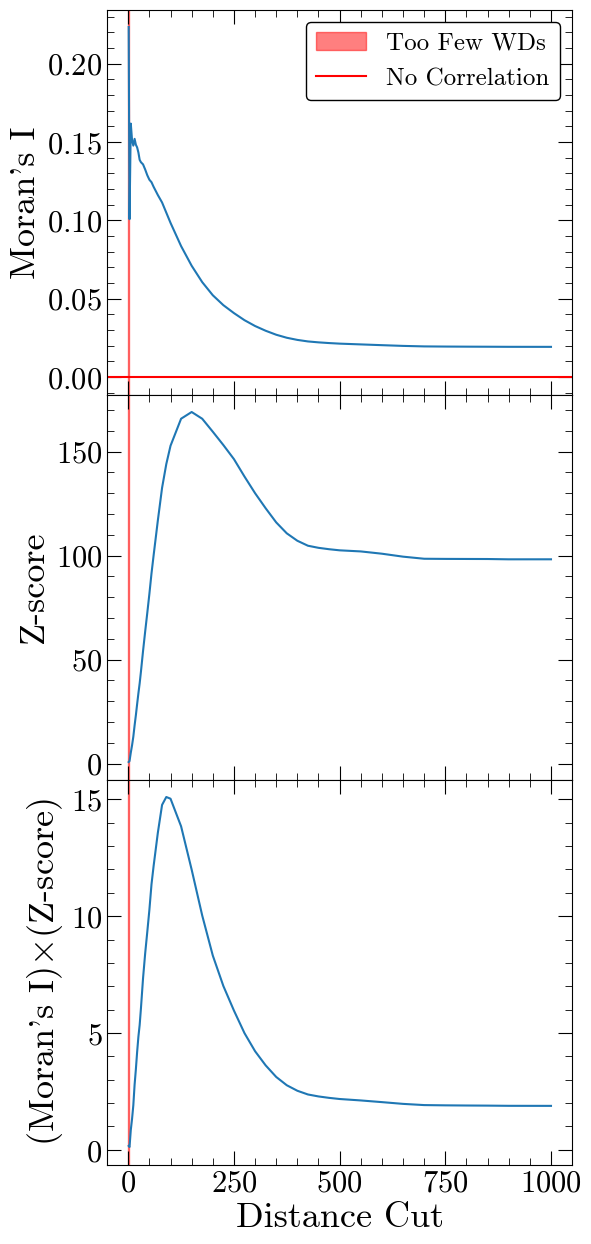

In [113]:
sample_size=len(reformat_wdtable)
output=get_output('csv/nb06_sample_size_'+str(sample_size)+'/data_measurement.npz',nonzero_weight_cut=20,plot=True)

# Check robustness of real-data signal
- Imparted by extinction map: Repeat measurementfor photometric results where do not correct for extinction to see if could be from extinction map
- Sampling bias: Randomly sample half of the catalog without replacement
- Position/Geometric bias: Take real positions of WDs and replace R deviation by a Gaussian variable with same mean and std as catalog

In [14]:
sample_size=len(reformat_wdtable)

#distance cut array
distances=np.array([1,3,6,9,12,15,18,21,24,27,30,35,40,45,50,55,60,70,80,90,100,125,150,175,200,225,250,275,300,325,350,375,400,
                    425,450,475,500,550,600,650,700,750,800,850,900,1000])

path,num_dfs_ijsum,med_abs_deviation=MoransI_contributions(reformat_wdtable_noext,sample_size,max_len=100000)

#calculate Moran's I for range of distances 
Ws,moransIs,expectations, variances,zscores=MoransI_calculation(path,num_dfs_ijsum,distances)

#path to save outputs
final_path='csv/nb06_sample_size_'+str(sample_size)
#make directory if does not exist
try:
    os.makedirs(final_path)
except:
    pass

#write the data in a txt file
np.savez(final_path+'/noext',Ws=Ws,med_abs_deviations=med_abs_deviation, distances=distances,moransIs=moransIs,expectations=expectations,variances=variances,zscores=zscores)  
  
#delete the intermediate files
shutil.rmtree(path)

100%|█████████████████████████████████████| 10207/10207 [19:02<00:00,  8.93it/s]


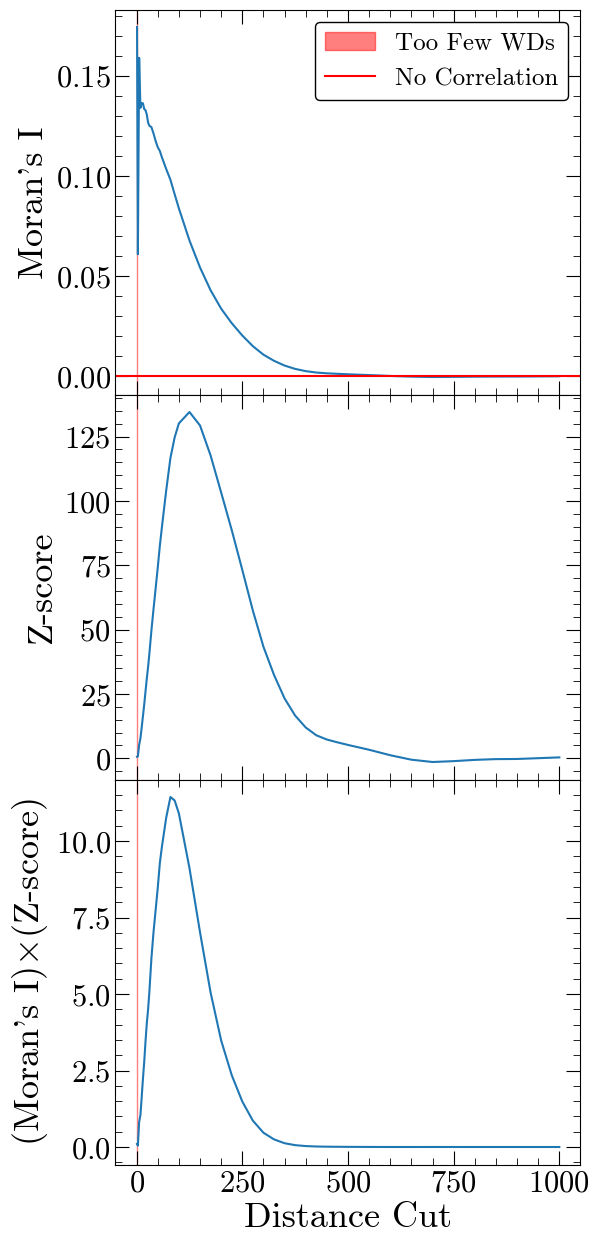

In [116]:
sample_size=len(reformat_wdtable)
output=get_output('csv/nb06_sample_size_'+str(sample_size)+'/data_measurement_noext.npz',nonzero_weight_cut=20,plot=True)

In [16]:
sample_size=len(reformat_wdtable)

#distance cut array
distances=np.array([1,3,6,9,12,15,18,21,24,27,30,35,40,45,50,55,60,70,80,90,100,125,150,175,200,225,250,275,300,325,350,375,400,
                    425,450,475,500,550,600,650,700,750,800,850,900,1000])

#re-sample the table of data
resampled_wdtable=reformat_wdtable.sample(n=int(len(reformat_wdtable)/2), replace=False)
#reset the indices
indices=np.arange(0,len(resampled_wdtable))
resampled_wdtable.set_index(indices,inplace=True)

path,num_dfs_ijsum,med_abs_deviation=MoransI_contributions(resampled_wdtable,sample_size,max_len=100000)

#calculate Moran's I for range of distances 
Ws,moransIs,expectations, variances,zscores=MoransI_calculation(path,num_dfs_ijsum,distances)

#path to save outputs
final_path='csv/nb06_sample_size_'+str(sample_size)
#make directory if does not exist
try:
    os.makedirs(final_path)
except:
    pass

#write the data in a txt file
np.savez(final_path+'/resampled',Ws=Ws,med_abs_deviations=med_abs_deviation, distances=distances,moransIs=moransIs,expectations=expectations,variances=variances,zscores=zscores)  


100%|███████████████████████████████████████| 5103/5103 [05:02<00:00, 16.90it/s]


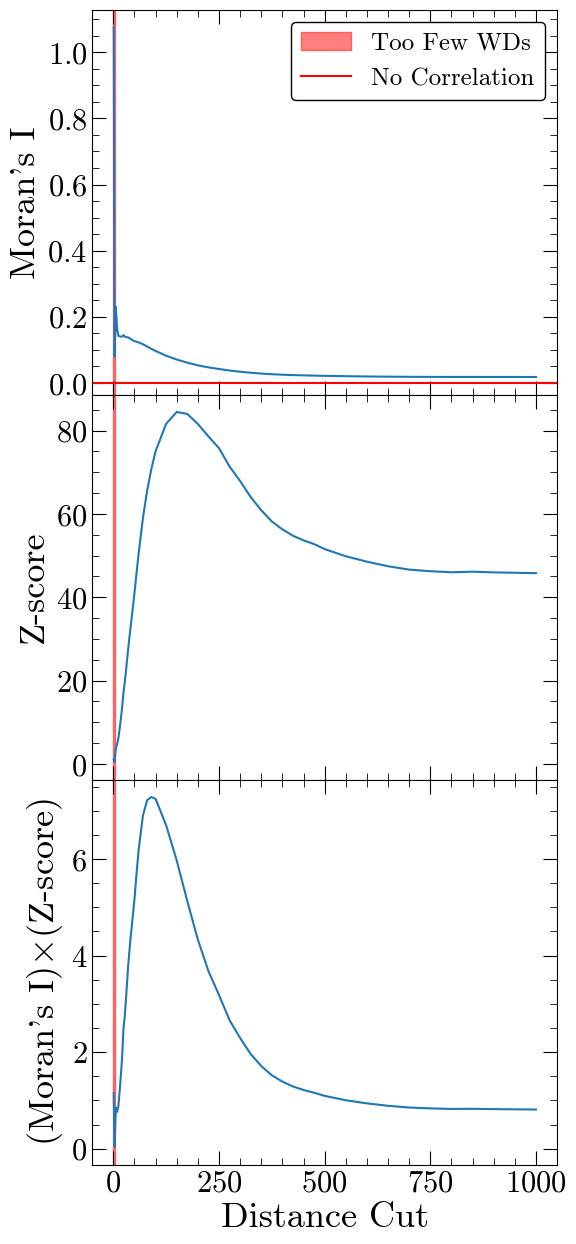

In [117]:
sample_size=len(reformat_wdtable)
output=get_output('csv/nb06_sample_size_'+str(sample_size)+'/resampled.npz',nonzero_weight_cut=20,plot=True)

In [18]:
sample_size=len(reformat_wdtable)

#distance cut array
distances=np.array([1,3,6,9,12,15,18,21,24,27,30,35,40,45,50,55,60,70,80,90,100,125,150,175,200,225,250,275,300,325,350,375,400,
                    425,450,475,500,550,600,650,700,750,800,850,900,1000])

path,num_dfs_ijsum,med_abs_deviation=MoransI_contributions(reformat_wdtable,sample_size,random_noise='mean',max_len=100000)

#calculate Moran's I for range of distances 
Ws,moransIs,expectations, variances,zscores=MoransI_calculation(path,num_dfs_ijsum,distances)

#path to save outputs
final_path='csv/nb06_sample_size_'+str(sample_size)
#make directory if does not exist
try:
    os.makedirs(final_path)
except:
    pass

#write the data in a txt file
np.savez(final_path+'/random_deviations',Ws=Ws,med_abs_deviations=med_abs_deviation, distances=distances,moransIs=moransIs,expectations=expectations,variances=variances,zscores=zscores)  


Random noise with mean deviation=sample mean


100%|█████████████████████████████████████| 10207/10207 [36:56<00:00,  4.61it/s]


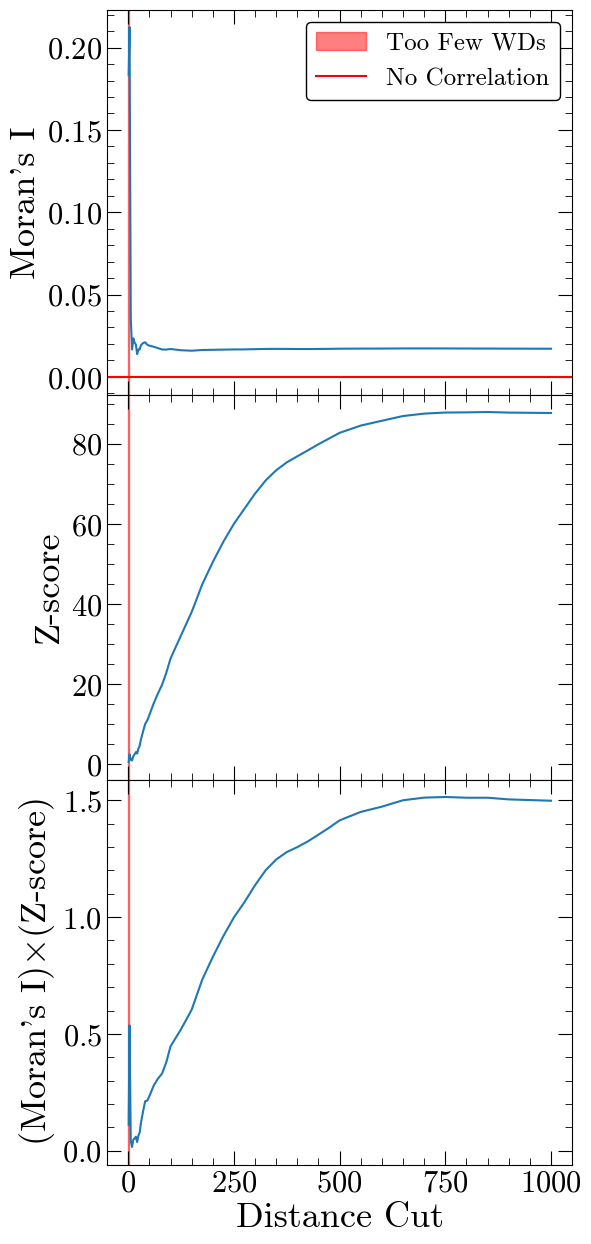

In [118]:
sample_size=len(reformat_wdtable)
output=get_output('csv/nb06_sample_size_'+str(sample_size)+'/random_deviations.npz',nonzero_weight_cut=20,plot=True)

In [20]:
sample_size=len(reformat_wdtable)

#distance cut array
distances=np.array([1,3,6,9,12,15,18,21,24,27,30,35,40,45,50,55,60,70,80,90,100,125,150,175,200,225,250,275,300,325,350,375,400,
                    425,450,475,500,550,600,650,700,750,800,850,900,1000])

path,num_dfs_ijsum,med_abs_deviation=MoransI_contributions(reformat_wdtable,sample_size,random_noise='0',max_len=100000)

#calculate Moran's I for range of distances 
Ws,moransIs,expectations, variances,zscores=MoransI_calculation(path,num_dfs_ijsum,distances)

#path to save outputs
final_path='csv/nb06_sample_size_'+str(sample_size)
#make directory if does not exist
try:
    os.makedirs(final_path)
except:
    pass

#write the data in a txt file
np.savez(final_path+'/random_deviations_0',Ws=Ws,med_abs_deviations=med_abs_deviation, distances=distances,moransIs=moransIs,expectations=expectations,variances=variances,zscores=zscores)  


Random noise with mean deviation=0


100%|█████████████████████████████████████| 10207/10207 [16:07<00:00, 10.55it/s]


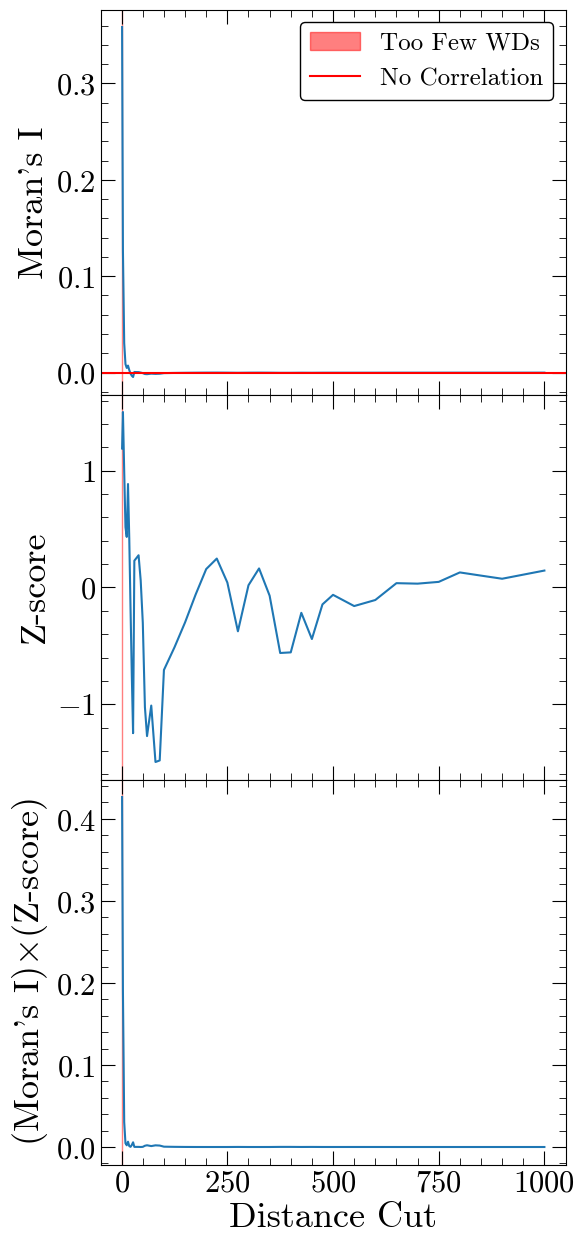

In [119]:
sample_size=len(reformat_wdtable)
output=get_output('csv/nb06_sample_size_'+str(sample_size)+'/random_deviations_0.npz',nonzero_weight_cut=20,plot=True)

# Use simulation 11 to measure the ULDM correlation length in the real data
I checked for consistency with the signal from the real data for simulations 8-11. Simulations 8-10 are too noisy, so that even at nonphysical epsilon=0.5 the signal is much more washed out (monotonically increasing Moran's I x Z-score curve at large separations) than we see in the real data.

In [3]:
def get_output_nb05(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                  remove_likely_binaries,sample_type,nonzero_weight_cut=20,plot=True):
    
    #sample_type='training','testing', or 'real_data'
    if sample_type=='training':
        noise_label="".join(noise_effect_array)
        #read back in measurements
        npzfile = np.load('csv/nb04_sample_size_'+str(sample_size)+'/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/training_data/ep_'+str(epsilon)+'_corr_'+str(corr_length)+'.npz')
        med_abs_deviations = npzfile['med_abs_deviations']
        
    if sample_type=='testing':
        noise_label="".join(noise_effect_array)
        #read back in measurements
        npzfile = np.load('csv/nb04_sample_size_'+str(sample_size)+'/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/testing_data/ep_'+str(epsilon)+'_corr_'+str(corr_length)+'.npz')
        med_abs_deviations = npzfile['med_abs_deviations']
    
    if sample_type=='real_data':
        #read back in measurements
        npzfile = np.load('csv/sim_real_signal_uldm/'+str(improvement_factor)+'_'+str(effect_strength)+'/ep_'+str(epsilon)+'_corr_'+str(corr_length)+'.npz')
        med_abs_deviations = npzfile['med_abs_deviations']     

    Ws = npzfile['Ws']
    final_distances = npzfile['distances']
    moransIs = npzfile['moransIs'] 
    expectations = npzfile['expectations']
    variances = npzfile['variances']
    zscores = npzfile['zscores']
    
    mult=[]
    for i in range(len(moransIs)):
        mult.append(moransIs[i]*zscores[i])
        
    #cut to make sure have enough nonzero weights for valid results
    index = bisect_left(Ws, nonzero_weight_cut)
    
    if plot:
        #plot
        fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)
        ax1.plot(final_distances,moransIs)
        ax1.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax1.axvline(corr_length,color='green',label='True Correlation\nLength')
        ax1.axhline(expectations[0],color='red',label='No Correlation')
        ax1.set_ylabel("Moran's I")
        ax1.legend()

        ax2.plot(final_distances,zscores)
        ax2.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax2.axvline(corr_length,color='green')
        ax2.set_ylabel('Z-score')

        ax3.plot(final_distances,mult)
        ax3.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax3.axvline(corr_length,color='green')
        ax3.set_xlabel('Distance Cut')
        ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")

        plt.subplots_adjust(wspace = 0,hspace=0)
        plt.show()
    
    return(final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index)

In [5]:
#for training data
corr_lengths=np.round(np.append(np.linspace(1,98,30)[1:],np.logspace(2,3,num=100)[1:-1]),2)
def round_sig(x,sig):
    return round(x, sig-int(floor(log10(abs(x))))-1)
epsilons_init=np.append(np.logspace(-10,-1,num=20),np.linspace(0.1,0.5,4)[1:])
epsilons=[]
for e in epsilons_init:
    epsilons.append(round_sig(e,2))
simulation_params=[]
for corr_length in corr_lengths:
    for epsilon in epsilons:
        simulation_params.append([corr_length,epsilon])
    

298.36 0.5


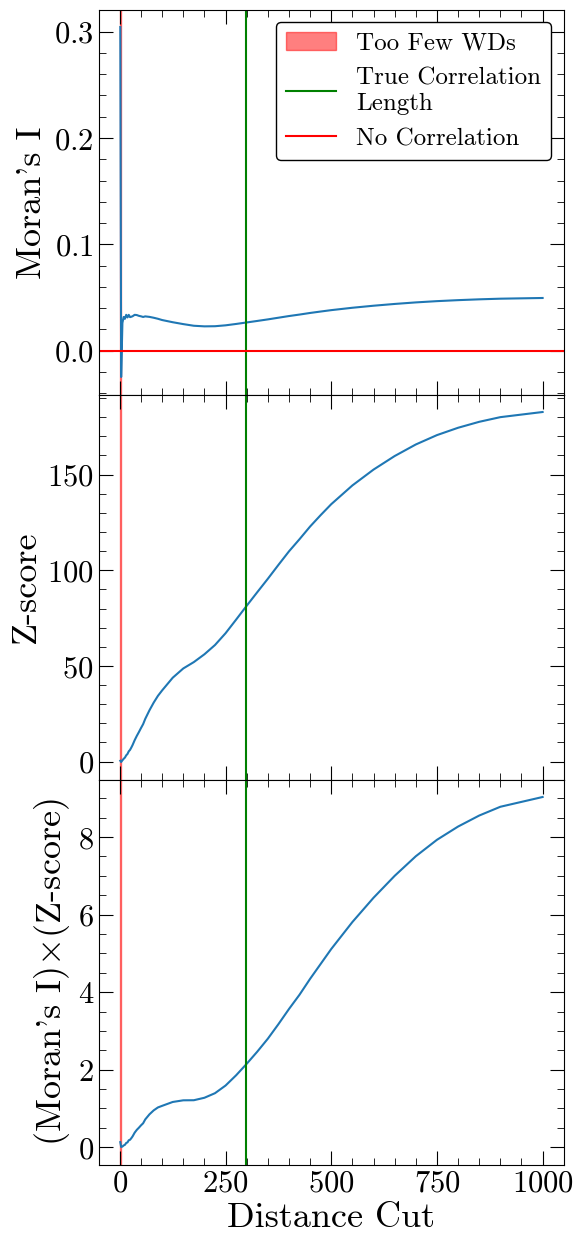

In [6]:
#check for consistency with the real data, nb08
sample_size=10207
noise_effect_array=['1','1','1','1','1']
improvement_factor=1
effect_strength=1
chance_companion=0.01
remove_likely_binaries='1'

corr_length=298.36
for epsilon in epsilons[len(epsilons)-1:]:
    print(corr_length,epsilon)
    output=get_output_nb05(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                  remove_likely_binaries,'training')

298.36 0.1


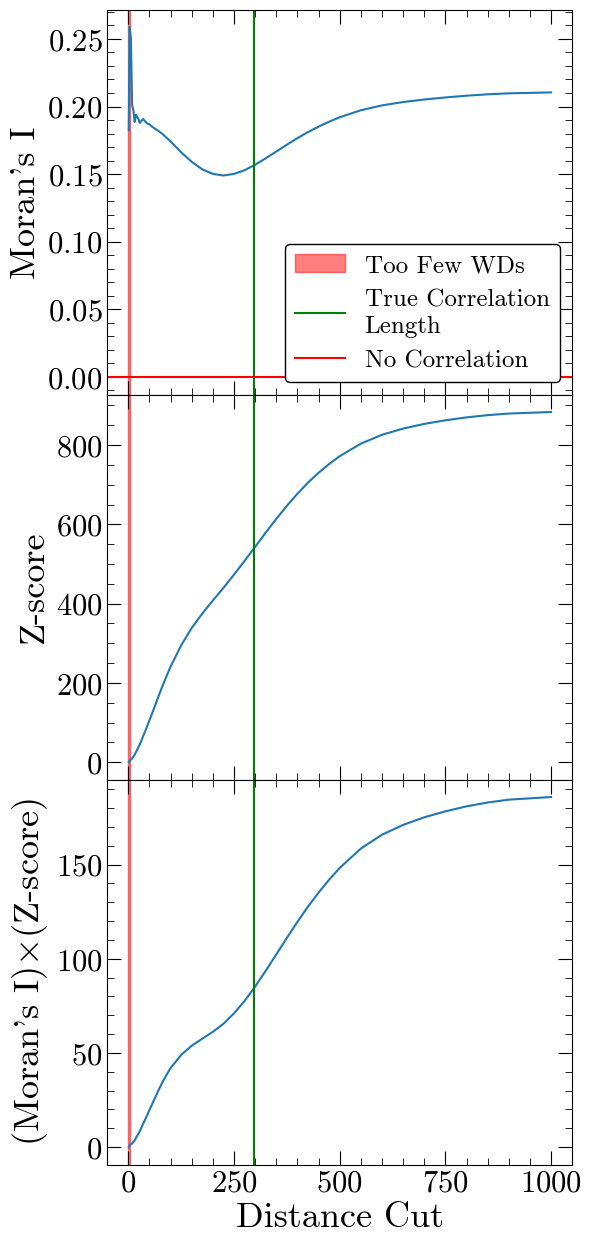

298.36 0.23


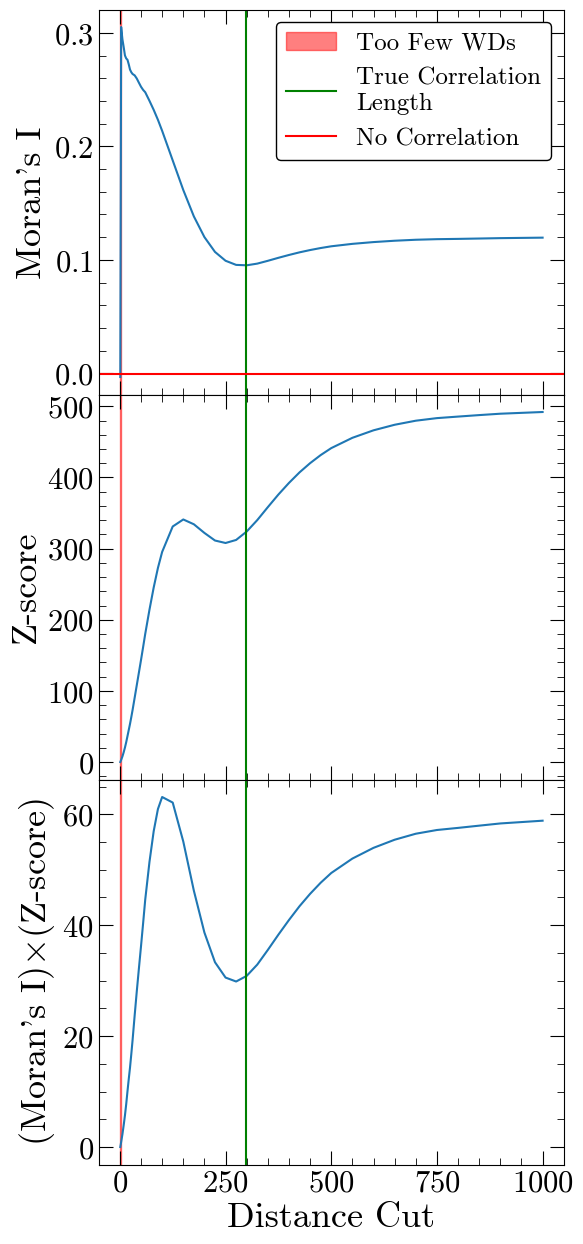

298.36 0.37


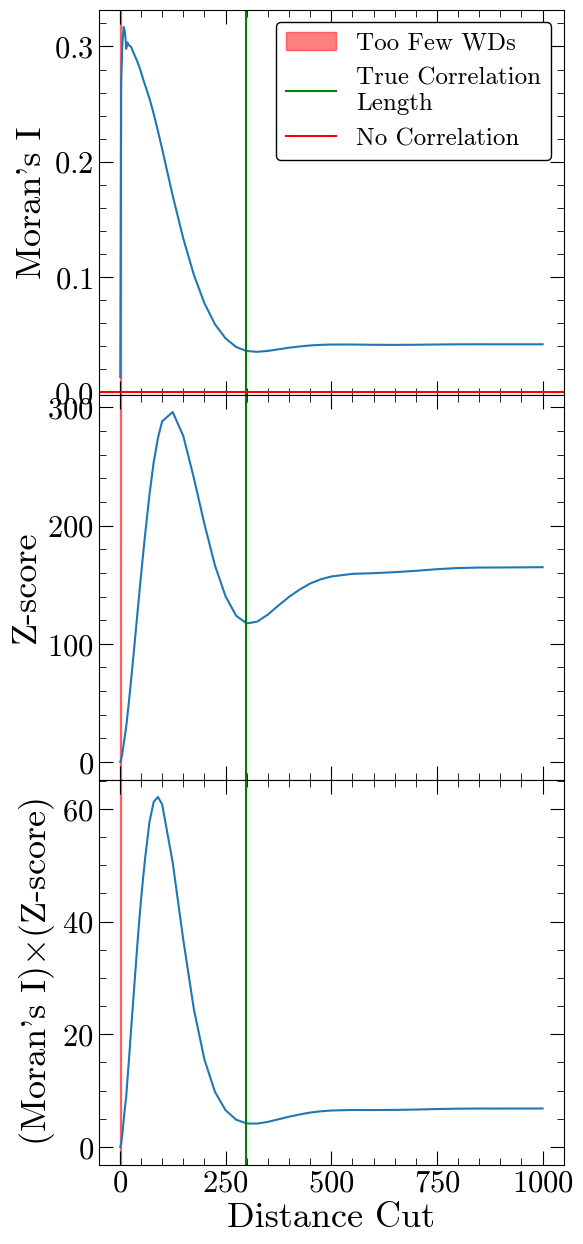

298.36 0.5


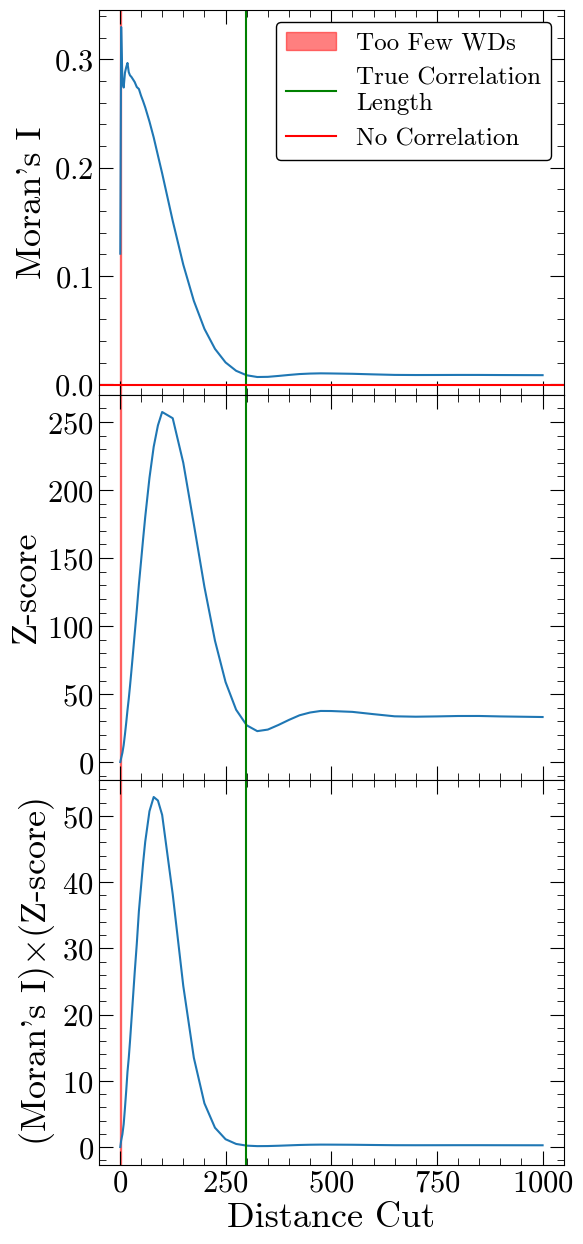

In [7]:
#check for consistency with the real data, nb09
sample_size=10207
noise_effect_array=['1','1','1','1','1']
improvement_factor=10
effect_strength=1
chance_companion=0.01
remove_likely_binaries='1'

corr_length=298.36
for epsilon in epsilons[len(epsilons)-4:]:
    print(corr_length,epsilon)
    output=get_output_nb05(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                  remove_likely_binaries,'training')

298.36 0.1


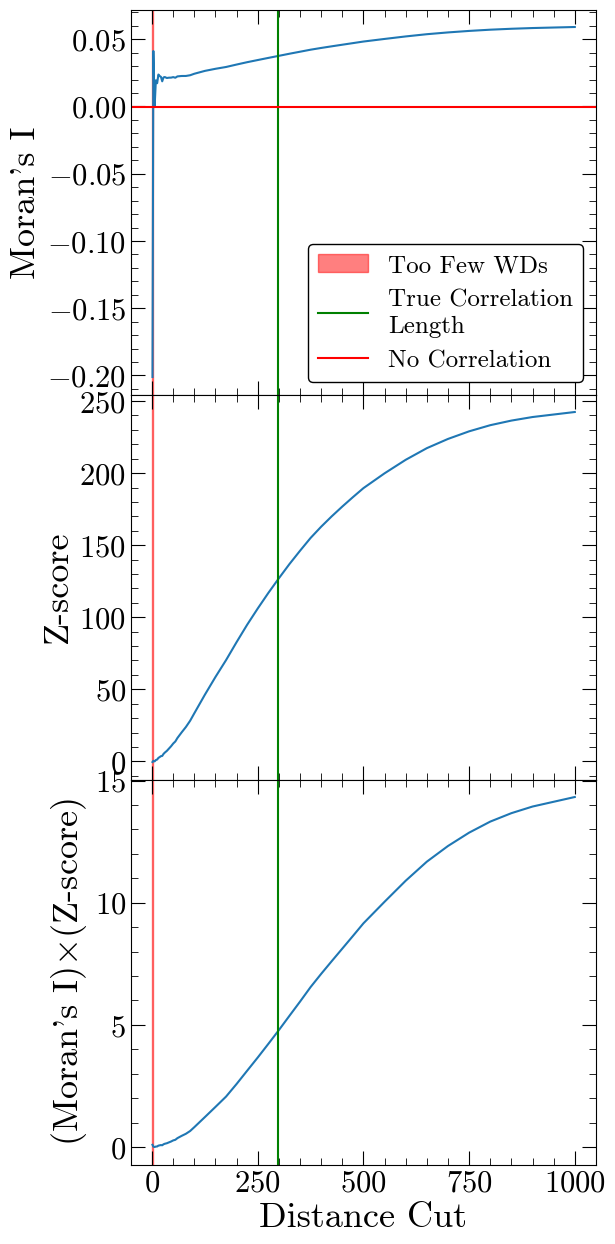

298.36 0.23


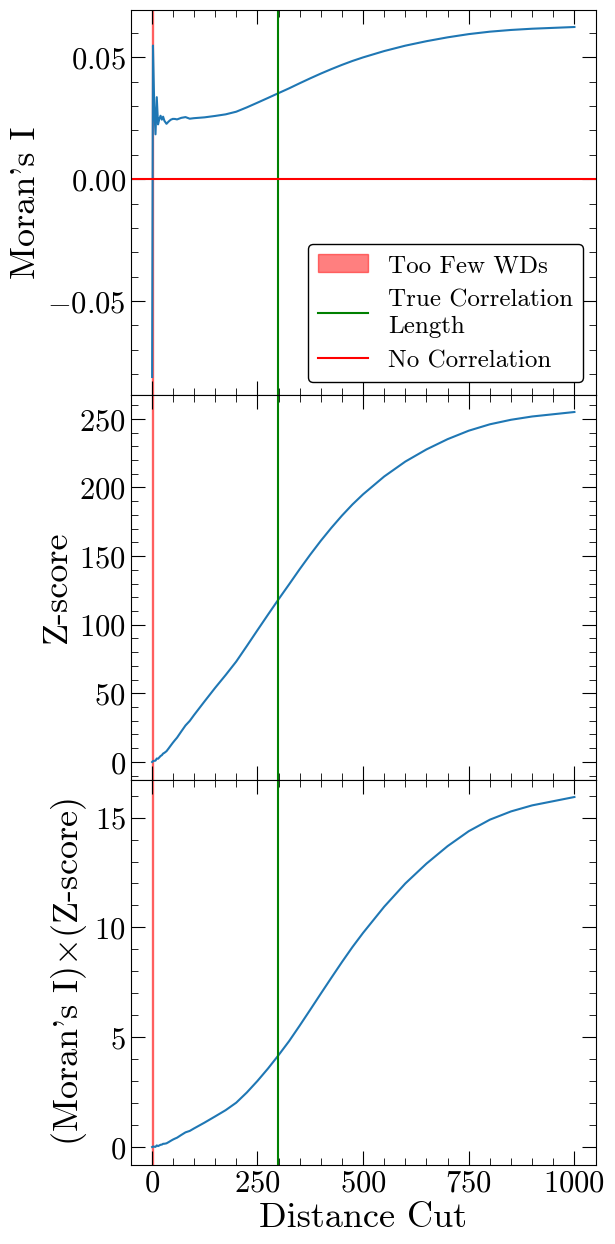

298.36 0.37


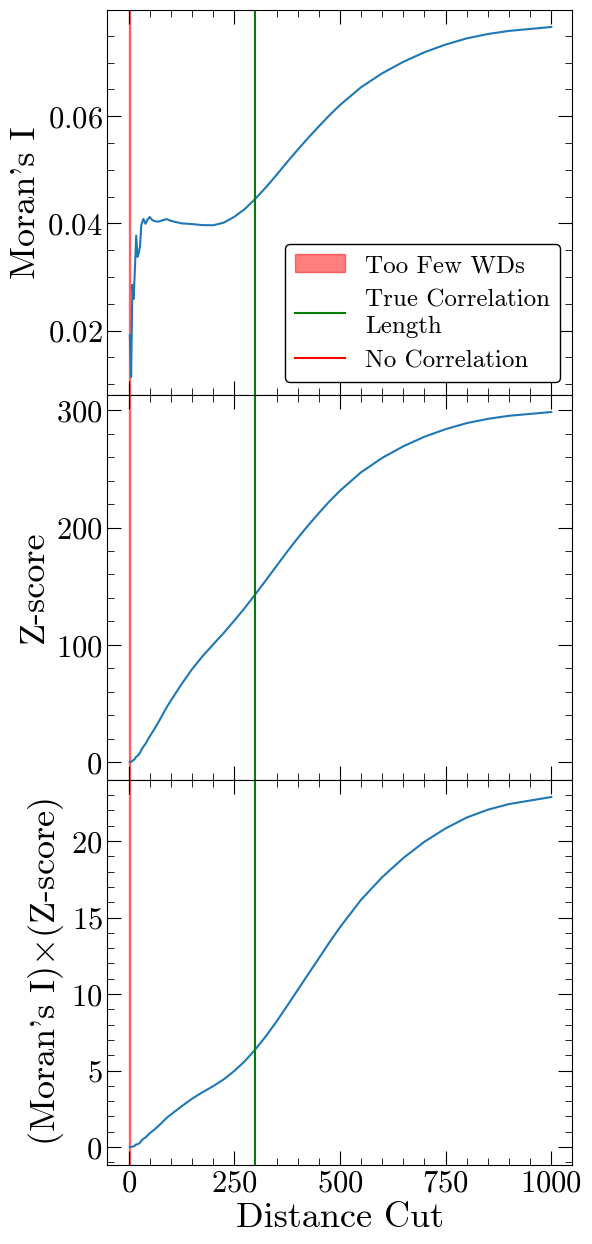

298.36 0.5


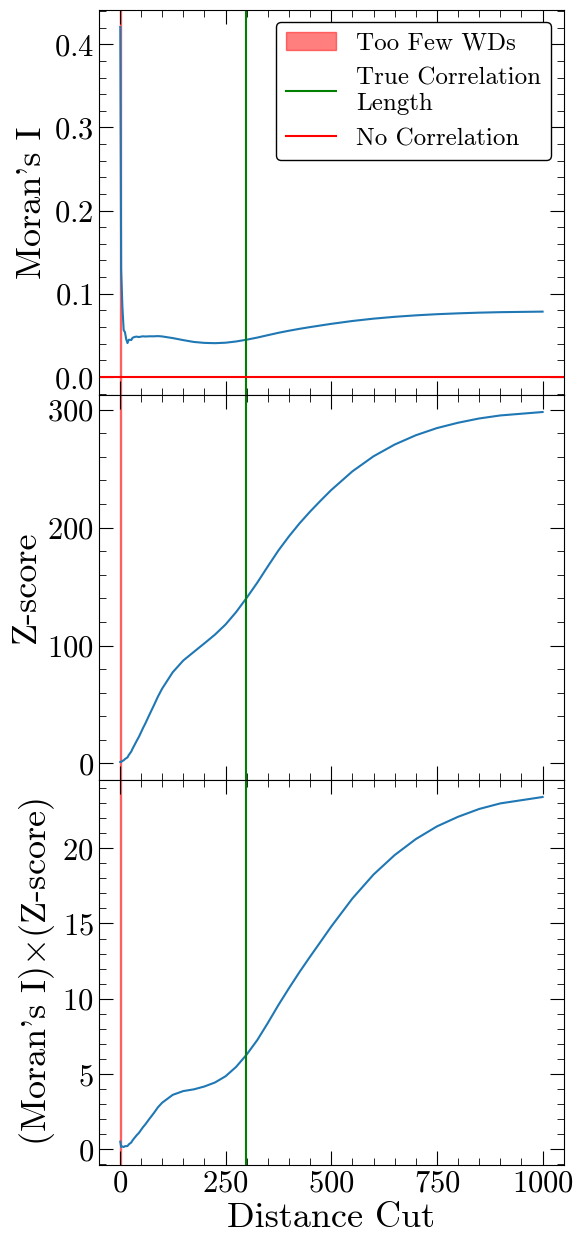

In [8]:
sample_size=10207
noise_effect_array=['1','1','1','1','1']
improvement_factor=1
effect_strength=10
chance_companion=0.01
remove_likely_binaries='1'

#check for consistency with the real data, nb10
corr_length=298.36
for epsilon in epsilons[len(epsilons)-4:]:
    print(corr_length,epsilon)
    output=get_output_nb05(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                  remove_likely_binaries,'training')

298.36 0.1


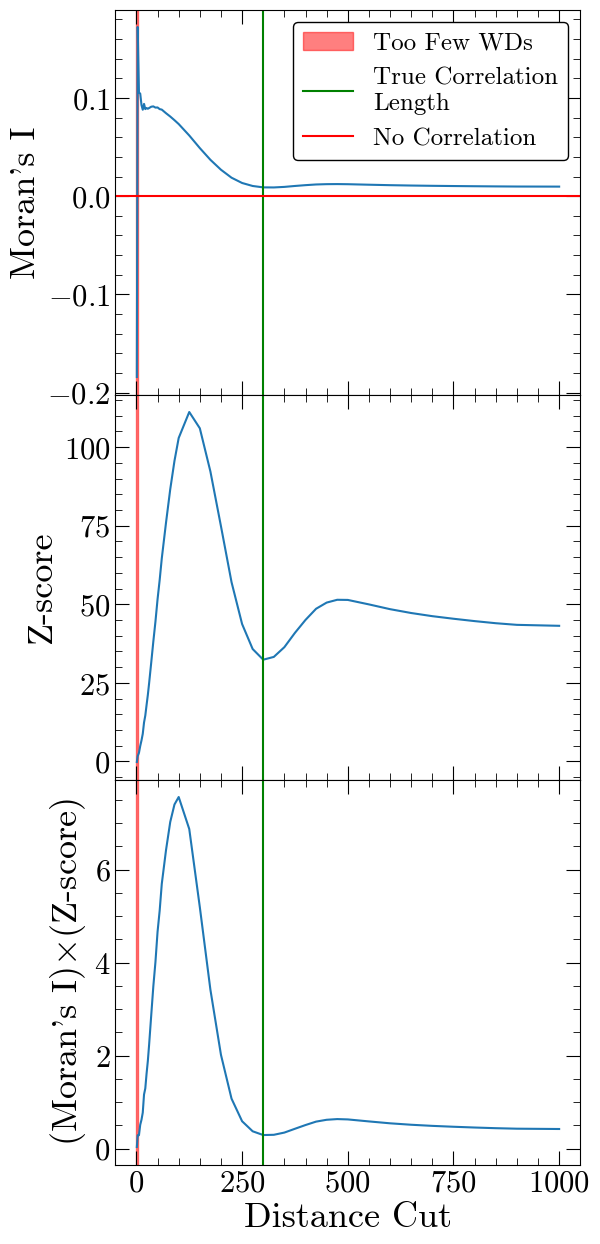

298.36 0.23


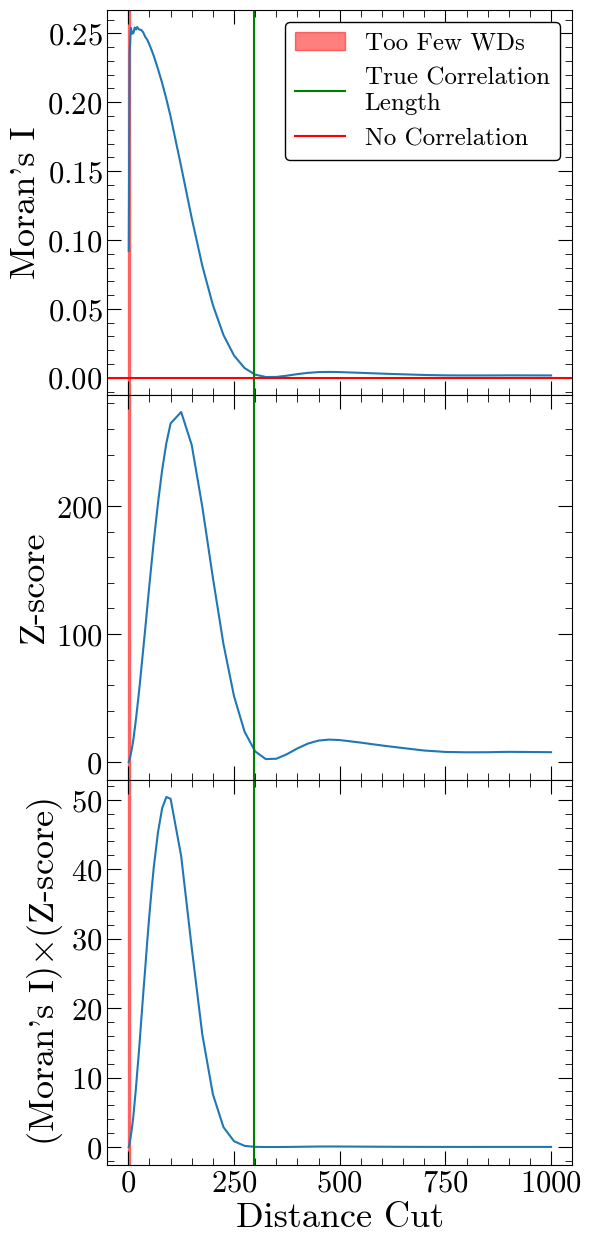

298.36 0.37


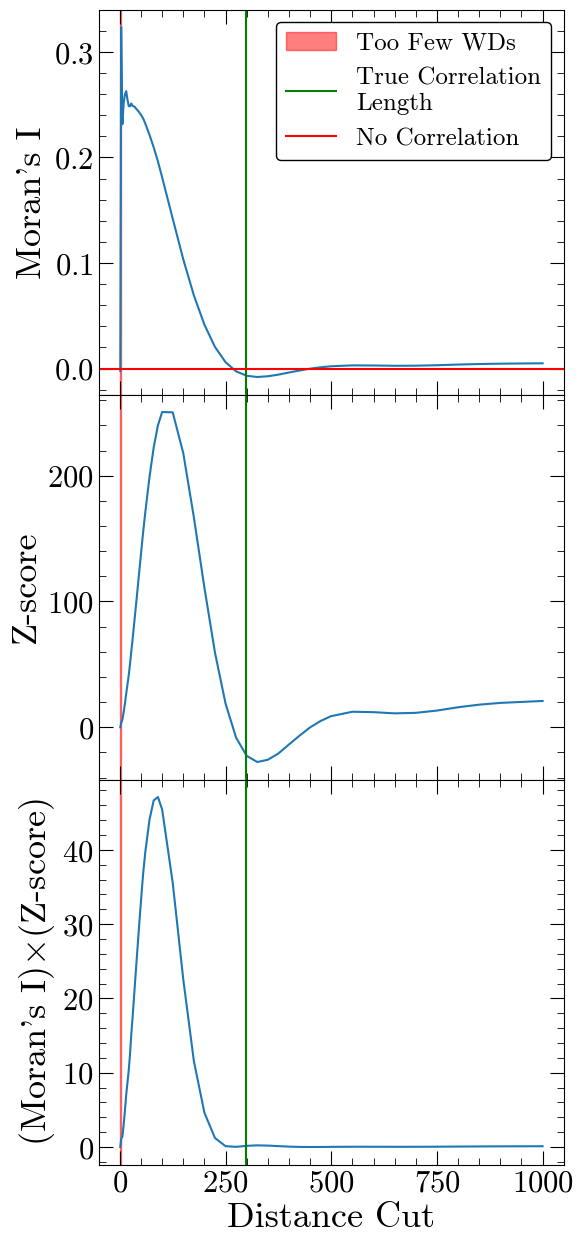

298.36 0.5


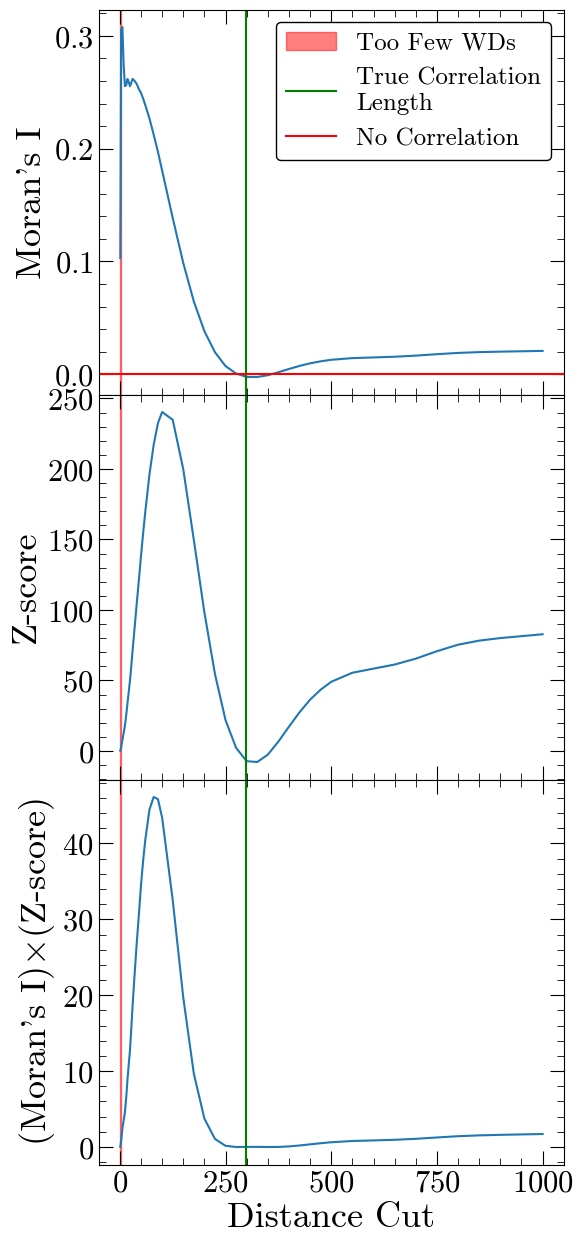

In [9]:
sample_size=10207
noise_effect_array=['1','1','1','1','1']
improvement_factor=10
effect_strength=10
chance_companion=0.01
remove_likely_binaries='1'

#check for consistency with the real data, nb11
corr_length=298.36
for epsilon in epsilons[len(epsilons)-4:]:
    print(corr_length,epsilon)
    output=get_output_nb05(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                  remove_likely_binaries,'training')

In [12]:
# format the data to be readable by the model
sample_size=10207

#corrected for extinction
x_corr_ext=[]
final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output('csv/nb06_sample_size_'+str(sample_size),nonzero_weight_cut=20,plot=False)
#Normalize then save Moran's I x Z-Score curve
normalized=mult/np.nanmax(np.abs(mult))
x_corr_ext.append(normalized)
x_corr_ext=np.array(x_corr_ext)
#check for NaNs and Infs
print(np.isnan(x_corr_ext).any())
print(np.isinf(x_corr_ext).any())


False
False


In [13]:
#initial measurement
model11 = load_model('csv/nb05_sample_size_10207/11_final_model')

# use the model to predict the data corrected for extinction
y_corr_ext11 = model11.predict(x_corr_ext, verbose=0)[0][0]
print('Measured ULDM correlation length for data 11=',y_corr_ext11,' pc')


Measured ULDM correlation length for data 11= 291.31192  pc


 ### There can be quite a bit of variation in the measurements from each CNN, so bootstrap the training sample and re-train 300 models for simulation 11 configuration. The final measurement is the mean across all the models and the uncertainty is the standard deviation

In [85]:
sample_size=10207
noise_effect_array=['1','1','1','1','1']
improvement_factor=10
effect_strength=10
chance_companion=0.01
remove_likely_binaries='1'

x_train=[]
y_train=[]
ep_train=[]
for simulation in simulation_params:
    corr_length=simulation[0]
    epsilon=simulation[1]
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output_nb05(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                                                                                                          remove_likely_binaries,'training',plot=False)
    #Normalize then save Moran's I x Z-Score curve as 1D training data
    normalized=mult/np.nanmax(np.abs(mult))
    x_train.append(normalized)
    #save correlation length as true label
    y_train.append(corr_length)
    #also save epsilon
    ep_train.append(epsilon)
    
x_train=np.array(x_train)
y_train=np.array(y_train)
ep_train=np.array(ep_train)

#there are NaNs in the data set from the d = 1pc cut having no WDs at that separation, set these NaNs to 0
x_train=np.nan_to_num(x_train)

#build 300 of these models and save the results
#model with even more layers, run for even more epochs
for i in tqdm(range(300)):
    try:
        #don't re-run if model already exists
        model = load_model('csv/nb05_sample_size_10207/final_model_11_'+str(i))
    except:
        #bootstrap the training data with replacement
        boot_ind= np.random.choice(len(y_train), size=len(y_train), replace=True)
        x_train_boot=x_train[boot_ind]
        y_train_boot=y_train[boot_ind]

        final_model = Sequential([
            Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)), 
            MaxPooling1D(2), 
            Conv1D(64, 3, activation='relu'),
            MaxPooling1D(2), 
            Conv1D(128, 3, activation='relu'), 
            MaxPooling1D(2), 
            Flatten(), 
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(1) 
        ])

        final_model.compile(optimizer='adam', loss='mse')

        final_model.fit(x_train_boot, y_train_boot, epochs=400, batch_size=32, verbose=0)

        final_model.save('csv/nb05_sample_size_10207/final_model_11_'+str(i))
    

 33%|█████████████▋                           | 100/300 [00:17<00:30,  6.49it/s]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_100/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_100/assets
 34%|█████████████▏                         | 101/300 [01:56<1:39:03, 29.87s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_101/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_101/assets
 34%|█████████████▎                         | 102/300 [03:34<2:45:19, 50.10s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_102/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_102/assets
 34%|█████████████▍                         | 103/300 [05:11<3:31:28, 64.41s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_103/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_103/assets
 35%|█████████████▌                         | 104/300 [06:53<4:06:59, 75.61s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_104/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_104/assets
 35%|█████████████▋                         | 105/300 [08:24<4:20:56, 80.29s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_105/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_105/assets
 35%|█████████████▊                         | 106/300 [09:53<4:27:42, 82.80s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_106/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_106/assets
 36%|█████████████▉                         | 107/300 [11:26<4:36:24, 85.93s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_107/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_107/assets
 36%|██████████████                         | 108/300 [13:01<4:43:34, 88.62s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_108/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_108/assets
 36%|██████████████▏                        | 109/300 [14:36<4:48:27, 90.61s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_109/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_109/assets
 37%|██████████████▎                        | 110/300 [16:12<4:51:12, 91.96s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_110/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_110/assets
 37%|██████████████▍                        | 111/300 [17:47<4:53:21, 93.13s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_111/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_111/assets
 37%|██████████████▌                        | 112/300 [19:20<4:51:29, 93.03s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_112/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_112/assets
 38%|██████████████▋                        | 113/300 [20:53<4:50:00, 93.05s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_113/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_113/assets
 38%|██████████████▊                        | 114/300 [22:29<4:51:07, 93.91s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_114/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_114/assets
 38%|██████████████▉                        | 115/300 [24:03<4:49:21, 93.85s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_115/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_115/assets
 39%|███████████████                        | 116/300 [25:36<4:47:30, 93.76s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_116/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_116/assets
 39%|███████████████▏                       | 117/300 [27:15<4:50:45, 95.33s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_117/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_117/assets
 39%|███████████████▎                       | 118/300 [28:55<4:53:05, 96.62s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_118/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_118/assets
 40%|███████████████▍                       | 119/300 [30:34<4:53:34, 97.32s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_119/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_119/assets
 40%|███████████████▌                       | 120/300 [32:12<4:52:08, 97.38s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_120/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_120/assets
 40%|███████████████▋                       | 121/300 [33:49<4:50:21, 97.33s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_121/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_121/assets
 41%|███████████████▊                       | 122/300 [35:27<4:49:50, 97.70s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_122/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_122/assets
 41%|███████████████▉                       | 123/300 [37:09<4:51:23, 98.78s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_123/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_123/assets
 41%|████████████████                       | 124/300 [38:50<4:52:00, 99.55s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_124/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_124/assets
 42%|████████████████▎                      | 125/300 [40:30<4:51:03, 99.79s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_125/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_125/assets
 42%|███████████████▉                      | 126/300 [42:13<4:52:11, 100.76s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_126/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_126/assets
 42%|████████████████                      | 127/300 [44:02<4:57:32, 103.20s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_127/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_127/assets
 43%|████████████████▏                     | 128/300 [45:46<4:56:25, 103.40s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_128/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_128/assets
 43%|████████████████▎                     | 129/300 [47:23<4:48:53, 101.37s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_129/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_129/assets
 43%|████████████████▉                      | 130/300 [48:58<4:41:39, 99.41s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_130/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_130/assets
 44%|█████████████████                      | 131/300 [50:32<4:35:38, 97.86s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_131/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_131/assets
 44%|█████████████████▏                     | 132/300 [52:07<4:31:44, 97.05s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_132/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_132/assets
 44%|█████████████████▎                     | 133/300 [53:40<4:27:11, 96.00s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_133/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_133/assets
 45%|█████████████████▍                     | 134/300 [55:14<4:23:30, 95.24s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_134/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_134/assets
 45%|█████████████████▌                     | 135/300 [56:52<4:24:06, 96.04s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_135/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_135/assets
 45%|█████████████████▋                     | 136/300 [58:31<4:24:43, 96.85s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_136/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_136/assets
 46%|████████████████▉                    | 137/300 [1:00:10<4:24:53, 97.51s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_137/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_137/assets
 46%|█████████████████                    | 138/300 [1:01:44<4:20:58, 96.65s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_138/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_138/assets
 46%|█████████████████▏                   | 139/300 [1:03:23<4:20:44, 97.17s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_139/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_139/assets
 47%|█████████████████▎                   | 140/300 [1:05:02<4:20:49, 97.81s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_140/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_140/assets
 47%|█████████████████▍                   | 141/300 [1:06:41<4:20:30, 98.31s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_141/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_141/assets
 47%|█████████████████▌                   | 142/300 [1:08:25<4:23:14, 99.97s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_142/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_142/assets
 48%|█████████████████▏                  | 143/300 [1:10:11<4:25:43, 101.55s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_143/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_143/assets
 48%|█████████████████▎                  | 144/300 [1:11:51<4:23:29, 101.34s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_144/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_144/assets
 48%|█████████████████▍                  | 145/300 [1:13:37<4:24:50, 102.52s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_145/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_145/assets
 49%|█████████████████▌                  | 146/300 [1:15:13<4:18:08, 100.57s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_146/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_146/assets
 49%|██████████████████▏                  | 147/300 [1:16:50<4:13:53, 99.56s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_147/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_147/assets
 49%|██████████████████▎                  | 148/300 [1:18:28<4:10:44, 98.98s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_148/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_148/assets
 50%|██████████████████▍                  | 149/300 [1:20:02<4:05:31, 97.56s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_149/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_149/assets
 50%|██████████████████▌                  | 150/300 [1:21:40<4:04:38, 97.86s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_150/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_150/assets
 50%|██████████████████▌                  | 151/300 [1:23:24<4:07:07, 99.51s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_151/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_151/assets
 51%|██████████████████▋                  | 152/300 [1:25:05<4:06:27, 99.91s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_152/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_152/assets
 51%|██████████████████▎                 | 153/300 [1:26:50<4:08:44, 101.53s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_153/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_153/assets
 51%|██████████████████▍                 | 154/300 [1:28:28<4:04:26, 100.45s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_154/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_154/assets
 52%|███████████████████                  | 155/300 [1:30:03<3:58:46, 98.80s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_155/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_155/assets
 52%|███████████████████▏                 | 156/300 [1:31:40<3:55:42, 98.22s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_156/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_156/assets
 52%|███████████████████▎                 | 157/300 [1:33:18<3:53:52, 98.13s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_157/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_157/assets
 53%|███████████████████▍                 | 158/300 [1:34:50<3:48:16, 96.45s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_158/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_158/assets
 53%|███████████████████▌                 | 159/300 [1:36:29<3:48:17, 97.15s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_159/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_159/assets
 53%|███████████████████▋                 | 160/300 [1:38:04<3:45:24, 96.61s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_160/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_160/assets
 54%|███████████████████▊                 | 161/300 [1:39:42<3:44:44, 97.01s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_161/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_161/assets
 54%|███████████████████▉                 | 162/300 [1:41:20<3:44:00, 97.39s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_162/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_162/assets
 54%|████████████████████                 | 163/300 [1:42:57<3:41:35, 97.05s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_163/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_163/assets
 55%|████████████████████▏                | 164/300 [1:44:31<3:38:20, 96.33s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_164/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_164/assets
 55%|████████████████████▎                | 165/300 [1:46:08<3:37:02, 96.46s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_165/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_165/assets
 55%|████████████████████▍                | 166/300 [1:47:44<3:35:12, 96.36s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_166/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_166/assets
 56%|████████████████████▌                | 167/300 [1:49:22<3:34:14, 96.65s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_167/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_167/assets
 56%|████████████████████▋                | 168/300 [1:50:59<3:33:06, 96.86s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_168/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_168/assets
 56%|████████████████████▊                | 169/300 [1:52:39<3:33:28, 97.78s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_169/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_169/assets
 57%|████████████████████▉                | 170/300 [1:54:23<3:36:06, 99.74s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_170/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_170/assets
 57%|█████████████████████                | 171/300 [1:55:58<3:31:32, 98.39s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_171/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_171/assets
 57%|█████████████████████▏               | 172/300 [1:57:35<3:28:41, 97.82s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_172/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_172/assets
 58%|█████████████████████▎               | 173/300 [1:59:10<3:25:32, 97.10s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_173/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_173/assets
 58%|█████████████████████▍               | 174/300 [2:00:49<3:24:57, 97.60s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_174/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_174/assets
 58%|█████████████████████▌               | 175/300 [2:02:28<3:24:23, 98.10s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_175/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_175/assets
 59%|█████████████████████▋               | 176/300 [2:04:09<3:24:25, 98.92s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_176/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_176/assets
 59%|█████████████████████▊               | 177/300 [2:05:47<3:22:21, 98.71s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_177/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_177/assets
 59%|█████████████████████▉               | 178/300 [2:07:30<3:23:18, 99.99s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_178/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_178/assets
 60%|██████████████████████               | 179/300 [2:09:08<3:20:17, 99.32s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_179/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_179/assets
 60%|██████████████████████▏              | 180/300 [2:10:47<3:18:15, 99.13s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_180/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_180/assets
 60%|██████████████████████▎              | 181/300 [2:12:22<3:14:05, 97.86s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_181/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_181/assets
 61%|██████████████████████▍              | 182/300 [2:14:04<3:15:05, 99.20s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_182/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_182/assets
 61%|█████████████████████▉              | 183/300 [2:15:47<3:15:35, 100.30s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_183/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_183/assets
 61%|██████████████████████▋              | 184/300 [2:17:25<3:12:52, 99.77s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_184/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_184/assets
 62%|██████████████████████▏             | 185/300 [2:19:08<3:13:00, 100.70s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_185/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_185/assets
 62%|██████████████████████▎             | 186/300 [2:20:57<3:15:39, 102.97s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_186/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_186/assets
 62%|██████████████████████▍             | 187/300 [2:22:47<3:18:01, 105.15s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_187/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_187/assets
 63%|██████████████████████▌             | 188/300 [2:24:31<3:15:54, 104.95s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_188/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_188/assets
 63%|██████████████████████▋             | 189/300 [2:26:06<3:08:19, 101.80s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_189/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_189/assets
 63%|██████████████████████▊             | 190/300 [2:27:49<3:07:27, 102.25s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_190/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_190/assets
 64%|██████████████████████▉             | 191/300 [2:29:25<3:02:36, 100.52s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_191/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_191/assets
 64%|███████████████████████▋             | 192/300 [2:31:01<2:58:18, 99.06s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_192/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_192/assets
 64%|███████████████████████▊             | 193/300 [2:32:37<2:54:47, 98.02s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_193/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_193/assets
 65%|███████████████████████▉             | 194/300 [2:34:16<2:54:02, 98.51s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_194/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_194/assets
 65%|████████████████████████             | 195/300 [2:35:55<2:52:37, 98.65s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_195/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_195/assets
 65%|████████████████████████▏            | 196/300 [2:37:32<2:49:43, 97.92s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_196/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_196/assets
 66%|████████████████████████▎            | 197/300 [2:39:07<2:46:52, 97.21s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_197/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_197/assets
 66%|████████████████████████▍            | 198/300 [2:40:44<2:45:11, 97.17s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_198/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_198/assets
 66%|████████████████████████▌            | 199/300 [2:42:19<2:42:31, 96.55s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_199/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_199/assets
 67%|████████████████████████▋            | 200/300 [2:43:56<2:41:14, 96.74s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_200/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_200/assets
 67%|████████████████████████▊            | 201/300 [2:45:35<2:40:34, 97.32s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_201/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_201/assets
 67%|████████████████████████▉            | 202/300 [2:47:07<2:36:29, 95.81s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_202/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_202/assets
 68%|█████████████████████████            | 203/300 [2:48:37<2:31:37, 93.79s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_203/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_203/assets
 68%|█████████████████████████▏           | 204/300 [2:50:14<2:31:57, 94.97s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_204/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_204/assets
 68%|█████████████████████████▎           | 205/300 [2:51:47<2:29:11, 94.23s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_205/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_205/assets
 69%|█████████████████████████▍           | 206/300 [2:53:22<2:28:19, 94.67s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_206/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_206/assets
 69%|█████████████████████████▌           | 207/300 [2:54:54<2:25:14, 93.71s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_207/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_207/assets
 69%|█████████████████████████▋           | 208/300 [2:56:25<2:22:38, 93.03s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_208/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_208/assets
 70%|█████████████████████████▊           | 209/300 [2:57:53<2:18:51, 91.56s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_209/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_209/assets
 70%|█████████████████████████▉           | 210/300 [2:59:21<2:15:42, 90.48s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_210/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_210/assets
 70%|██████████████████████████           | 211/300 [3:00:50<2:13:34, 90.05s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_211/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_211/assets
 71%|██████████████████████████▏          | 212/300 [3:02:21<2:12:26, 90.31s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_212/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_212/assets
 71%|██████████████████████████▎          | 213/300 [3:03:50<2:10:10, 89.78s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_213/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_213/assets
 71%|██████████████████████████▍          | 214/300 [3:05:20<2:08:36, 89.72s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_214/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_214/assets
 72%|██████████████████████████▌          | 215/300 [3:06:49<2:06:50, 89.53s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_215/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_215/assets
 72%|██████████████████████████▋          | 216/300 [3:08:20<2:06:07, 90.09s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_216/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_216/assets
 72%|██████████████████████████▊          | 217/300 [3:09:52<2:05:30, 90.73s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_217/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_217/assets
 73%|██████████████████████████▉          | 218/300 [3:11:24<2:04:36, 91.17s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_218/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_218/assets
 73%|███████████████████████████          | 219/300 [3:13:03<2:05:58, 93.32s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_219/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_219/assets
 73%|███████████████████████████▏         | 220/300 [3:14:42<2:06:51, 95.14s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_220/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_220/assets
 74%|███████████████████████████▎         | 221/300 [3:16:16<2:04:53, 94.86s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_221/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_221/assets
 74%|███████████████████████████▍         | 222/300 [3:17:48<2:02:06, 93.93s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_222/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_222/assets
 74%|███████████████████████████▌         | 223/300 [3:19:20<1:59:38, 93.23s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_223/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_223/assets
 75%|███████████████████████████▋         | 224/300 [3:20:59<2:00:24, 95.05s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_224/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_224/assets
 75%|███████████████████████████▊         | 225/300 [3:22:39<2:00:46, 96.62s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_225/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_225/assets
 75%|███████████████████████████▊         | 226/300 [3:24:11<1:57:09, 94.99s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_226/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_226/assets
 76%|███████████████████████████▉         | 227/300 [3:25:43<1:54:28, 94.10s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_227/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_227/assets
 76%|████████████████████████████         | 228/300 [3:27:19<1:53:45, 94.79s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_228/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_228/assets
 76%|████████████████████████████▏        | 229/300 [3:29:00<1:54:22, 96.65s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_229/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_229/assets
 77%|████████████████████████████▎        | 230/300 [3:30:42<1:54:43, 98.34s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_230/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_230/assets
 77%|████████████████████████████▍        | 231/300 [3:32:15<1:51:18, 96.79s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_231/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_231/assets
 77%|████████████████████████████▌        | 232/300 [3:33:48<1:48:08, 95.42s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_232/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_232/assets
 78%|████████████████████████████▋        | 233/300 [3:35:26<1:47:25, 96.20s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_233/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_233/assets
 78%|████████████████████████████▊        | 234/300 [3:37:10<1:48:23, 98.53s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_234/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_234/assets
 78%|████████████████████████████▏       | 235/300 [3:39:00<1:50:35, 102.09s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_235/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_235/assets
 79%|████████████████████████████▎       | 236/300 [3:40:38<1:47:38, 100.92s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_236/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_236/assets
 79%|████████████████████████████▍       | 237/300 [3:42:24<1:47:28, 102.36s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_237/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_237/assets
 79%|████████████████████████████▌       | 238/300 [3:44:05<1:45:19, 101.93s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_238/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_238/assets
 80%|████████████████████████████▋       | 239/300 [3:45:41<1:42:00, 100.33s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_239/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_239/assets
 80%|█████████████████████████████▌       | 240/300 [3:47:15<1:38:25, 98.43s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_240/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_240/assets
 80%|█████████████████████████████▋       | 241/300 [3:48:50<1:35:31, 97.14s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_241/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_241/assets
 81%|█████████████████████████████▊       | 242/300 [3:50:23<1:32:51, 96.06s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_242/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_242/assets
 81%|█████████████████████████████▉       | 243/300 [3:51:56<1:30:19, 95.07s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_243/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_243/assets
 81%|██████████████████████████████       | 244/300 [3:53:32<1:28:58, 95.34s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_244/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_244/assets
 82%|██████████████████████████████▏      | 245/300 [3:55:10<1:28:14, 96.26s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_245/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_245/assets
 82%|██████████████████████████████▎      | 246/300 [3:56:51<1:27:53, 97.65s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_246/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_246/assets
 82%|██████████████████████████████▍      | 247/300 [3:58:24<1:24:54, 96.13s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_247/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_247/assets
 83%|██████████████████████████████▌      | 248/300 [3:59:58<1:22:49, 95.57s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_248/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_248/assets
 83%|██████████████████████████████▋      | 249/300 [4:01:35<1:21:42, 96.13s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_249/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_249/assets
 83%|██████████████████████████████▊      | 250/300 [4:03:15<1:21:03, 97.28s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_250/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_250/assets
 84%|██████████████████████████████▉      | 251/300 [4:04:57<1:20:25, 98.48s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_251/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_251/assets
 84%|███████████████████████████████      | 252/300 [4:06:35<1:18:49, 98.53s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_252/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_252/assets
 84%|███████████████████████████████▏     | 253/300 [4:08:14<1:17:10, 98.52s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_253/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_253/assets
 85%|███████████████████████████████▎     | 254/300 [4:09:55<1:16:08, 99.31s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_254/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_254/assets
 85%|███████████████████████████████▍     | 255/300 [4:11:31<1:13:39, 98.21s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_255/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_255/assets
 85%|███████████████████████████████▌     | 256/300 [4:13:08<1:11:47, 97.89s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_256/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_256/assets
 86%|███████████████████████████████▋     | 257/300 [4:14:46<1:10:10, 97.91s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_257/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_257/assets
 86%|███████████████████████████████▊     | 258/300 [4:16:25<1:08:45, 98.22s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_258/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_258/assets
 86%|███████████████████████████████▉     | 259/300 [4:18:08<1:08:10, 99.76s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_259/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_259/assets
 87%|███████████████████████████████▏    | 260/300 [4:19:53<1:07:34, 101.35s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_260/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_260/assets
 87%|███████████████████████████████▎    | 261/300 [4:21:39<1:06:50, 102.84s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_261/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_261/assets
 87%|███████████████████████████████▍    | 262/300 [4:23:13<1:03:20, 100.01s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_262/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_262/assets
 88%|████████████████████████████████▍    | 263/300 [4:24:52<1:01:26, 99.63s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_263/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_263/assets
 88%|██████████████████████████████████▎    | 264/300 [4:26:31<59:40, 99.47s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_264/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_264/assets
 88%|██████████████████████████████████▍    | 265/300 [4:28:06<57:18, 98.24s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_265/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_265/assets
 89%|██████████████████████████████████▌    | 266/300 [4:29:42<55:15, 97.52s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_266/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_266/assets
 89%|██████████████████████████████████▋    | 267/300 [4:31:15<52:56, 96.25s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_267/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_267/assets
 89%|██████████████████████████████████▊    | 268/300 [4:32:51<51:20, 96.26s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_268/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_268/assets
 90%|██████████████████████████████████▉    | 269/300 [4:34:33<50:32, 97.83s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_269/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_269/assets
 90%|███████████████████████████████████    | 270/300 [4:36:06<48:12, 96.41s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_270/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_270/assets
 90%|███████████████████████████████████▏   | 271/300 [4:37:44<46:51, 96.93s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_271/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_271/assets
 91%|███████████████████████████████████▎   | 272/300 [4:39:20<45:03, 96.56s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_272/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_272/assets
 91%|███████████████████████████████████▍   | 273/300 [4:40:52<42:55, 95.38s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_273/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_273/assets
 91%|███████████████████████████████████▌   | 274/300 [4:42:29<41:30, 95.81s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_274/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_274/assets
 92%|███████████████████████████████████▊   | 275/300 [4:44:04<39:47, 95.48s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_275/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_275/assets
 92%|███████████████████████████████████▉   | 276/300 [4:45:47<39:05, 97.71s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_276/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_276/assets
 92%|████████████████████████████████████   | 277/300 [4:47:30<38:06, 99.41s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_277/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_277/assets
 93%|███████████████████████████████████▏  | 278/300 [4:49:12<36:40, 100.04s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_278/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_278/assets
 93%|███████████████████████████████████▎  | 279/300 [4:50:52<35:02, 100.14s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_279/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_279/assets
 93%|████████████████████████████████████▍  | 280/300 [4:52:24<32:31, 97.55s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_280/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_280/assets
 94%|████████████████████████████████████▌  | 281/300 [4:53:59<30:43, 97.00s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_281/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_281/assets
 94%|███████████████████████████████████▋  | 282/300 [4:55:47<30:04, 100.22s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_282/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_282/assets
 94%|███████████████████████████████████▊  | 283/300 [4:57:40<29:28, 104.01s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_283/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_283/assets
 95%|███████████████████████████████████▉  | 284/300 [4:59:22<27:36, 103.55s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_284/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_284/assets
 95%|████████████████████████████████████  | 285/300 [5:00:58<25:16, 101.08s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_285/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_285/assets
 95%|████████████████████████████████████▏ | 286/300 [5:02:41<23:46, 101.86s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_286/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_286/assets
 96%|████████████████████████████████████▎ | 287/300 [5:04:19<21:46, 100.47s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_287/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_287/assets
 96%|█████████████████████████████████████▍ | 288/300 [5:05:57<19:57, 99.81s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_288/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_288/assets
 96%|████████████████████████████████████▌ | 289/300 [5:07:40<18:27, 100.72s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_289/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_289/assets
 97%|█████████████████████████████████████▋ | 290/300 [5:09:17<16:36, 99.65s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_290/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_290/assets
 97%|████████████████████████████████████▊ | 291/300 [5:11:00<15:06, 100.69s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_291/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_291/assets
 97%|████████████████████████████████████▉ | 292/300 [5:12:47<13:39, 102.44s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_292/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_292/assets
 98%|█████████████████████████████████████ | 293/300 [5:14:34<12:08, 104.01s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_293/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_293/assets
 98%|█████████████████████████████████████▏| 294/300 [5:16:18<10:24, 104.06s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_294/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_294/assets
 98%|█████████████████████████████████████▎| 295/300 [5:18:06<08:45, 105.13s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_295/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_295/assets
 99%|█████████████████████████████████████▍| 296/300 [5:19:44<06:51, 102.90s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_296/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_296/assets
 99%|██████████████████████████████████████▌| 297/300 [5:21:17<04:59, 99.94s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_297/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_297/assets
 99%|██████████████████████████████████████▋| 298/300 [5:22:52<03:16, 98.42s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_298/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_298/assets
100%|██████████████████████████████████████▊| 299/300 [5:24:25<01:36, 96.86s/it]

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_299/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/final_model_11_299/assets
100%|███████████████████████████████████████| 300/300 [5:25:59<00:00, 65.20s/it]


300 300
Across all bootstrapped models the correlation length is
296.69427 +- 45.58832


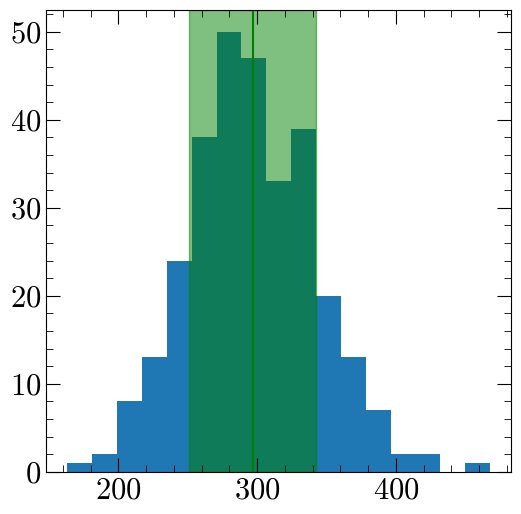

In [36]:
#use each of the 300 models to predict the correlation length from the real data
y_corr_ext_11s=[]
for i in range(300):
    model = load_model('csv/nb05_sample_size_10207/final_model_11_'+str(i))
    # use the model to predict the data corrected for extinction
    y_corr_ext_11 = model.predict(x_corr_ext, verbose=0)[0][0]
    y_corr_ext_11s.append(y_corr_ext_11)
y_corr_ext_11s=np.array(y_corr_ext_11s)

#restrict to only physical correlation lengths (<1000pc)
y_corr_ext_11s_filt=y_corr_ext_11s[y_corr_ext_11s < 1000]
print(len(y_corr_ext_11s),len(y_corr_ext_11s_filt))

mean_y_corr_ext_11=np.mean(y_corr_ext_11s_filt)
e_y_corr_ext_11=np.std(y_corr_ext_11s_filt)
print('Across all bootstrapped models the correlation length is')
print(mean_y_corr_ext_11,'+-',e_y_corr_ext_11)

fig, ax1 = plt.subplots(1,1,figsize=(6,6))
ax1.hist(y_corr_ext_11s_filt)
ax1.axvline(mean_y_corr_ext_11,color='green')
ax1.axvspan(mean_y_corr_ext_11-e_y_corr_ext_11,mean_y_corr_ext_11+e_y_corr_ext_11,color='green',alpha=0.5)


# Using simulation 11, measurement is corr length=300 +-50 pc
Run a bunch of simulations on Rockfish for
- effect_strength,improvement_factor=(5,8.5,10,12.5,15)
- corrlength between 250 and 350 pc
- epsilon between 0.01 and 0.5
Then I will import the simulations here and find the simulation with minimum distance (|simulation-real data| for Moran's I curve) to display on the final plot

In [234]:
#to compare to real measurement
corr_lengths=np.arange(250,355,5)

def round_sig(x,sig):
    return round(x, sig-int(floor(log10(abs(x))))-1)
epsilons_init=np.append(np.logspace(-2,-1,num=20),np.linspace(0.1,0.5,10)[1:])
epsilons=[]
for e in epsilons_init:
    epsilons.append(round_sig(e,2))

improvement_factors=[5,8.5,10,12.5,15]

effect_strengths=[5,8.5,10,12.5,15]
    
simulation_params=[]
for effect_strength in effect_strengths:
    for improvement_factor in improvement_factors:
        for corr_length in corr_lengths:
            for epsilon in epsilons:
                simulation_params.append([effect_strength,improvement_factor,corr_length,epsilon])
print(len(simulation_params))

#if break up by effect strength, then each set has ~3000 simulations, so do this to run on rockfish

15225


In [235]:
simulation_params_not_run=[]
simulation_params_run=[]

#check if each training data simulation has been run
for i in range(len(simulation_params)):
    simulation=simulation_params[i]
    effect_strength=simulation[0]
    improvement_factor=simulation[1]
    corr_length=simulation[2]
    epsilon=simulation[3]
    try:
        out=get_output_nb05(corr_length,epsilon,None,None,improvement_factor,effect_strength,None,
                  None,'real_data',plot=False)
        simulation_params_run.append(simulation)
    except:
        simulation_params_not_run.append(simulation)
        
print(len(simulation_params_run))
print(len(simulation_params_not_run))

15225
0


In [237]:
sample_size=10207
final_distances_real,med_abs_deviations_real,Ws_real,moransIs_real,expectations_real,variances_real,zscores_real,mult_real,index_real=get_output('csv/nb06_sample_size_10207/data_measurement.npz',nonzero_weight_cut=20,plot=False)

comparison=pd.DataFrame()

effect_strengths=[]
improvement_factors=[]
corr_lengths=[]
epsilons=[]
max_abs_diffs=[]
min_abs_diffs=[]
med_abs_diffs=[]
sum_abs_diffs=[]

for i in range(len(simulation_params_run)):
    simulation=simulation_params_run[i]

    effect_strength=simulation[0]
    improvement_factor=simulation[1]
    corr_length=simulation[2]
    epsilon=simulation[3]
    
    effect_strengths.append(effect_strength)
    improvement_factors.append(improvement_factor)
    corr_lengths.append(corr_length)
    epsilons.append(epsilon)

    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output_nb05(corr_length,epsilon,None,None,improvement_factor,effect_strength,None,
                      None,'real_data',plot=False)

    #get the difference between the simulation and the real data
    #exclude the data points for separations<10 since these can be very noisy
    differences=np.array(mult_real[4:])-np.array(mult[4:])
    abs_diff=np.abs(differences)

    max_abs_diffs.append(max(abs_diff))
    min_abs_diffs.append(min(abs_diff))
    med_abs_diffs.append(np.median(abs_diff))
    sum_abs_diffs.append(np.sum(abs_diff))
    
comparison['effect_strength']=effect_strengths
comparison['improvement_factor']=improvement_factors
comparison['corr_length']=corr_lengths
comparison['epsilon']=epsilons
comparison['max_abs_diff']=max_abs_diffs
comparison['min_abs_diff']=min_abs_diffs
comparison['med_abs_diff']=med_abs_diffs
comparison['sum_abs_diff']=sum_abs_diffs

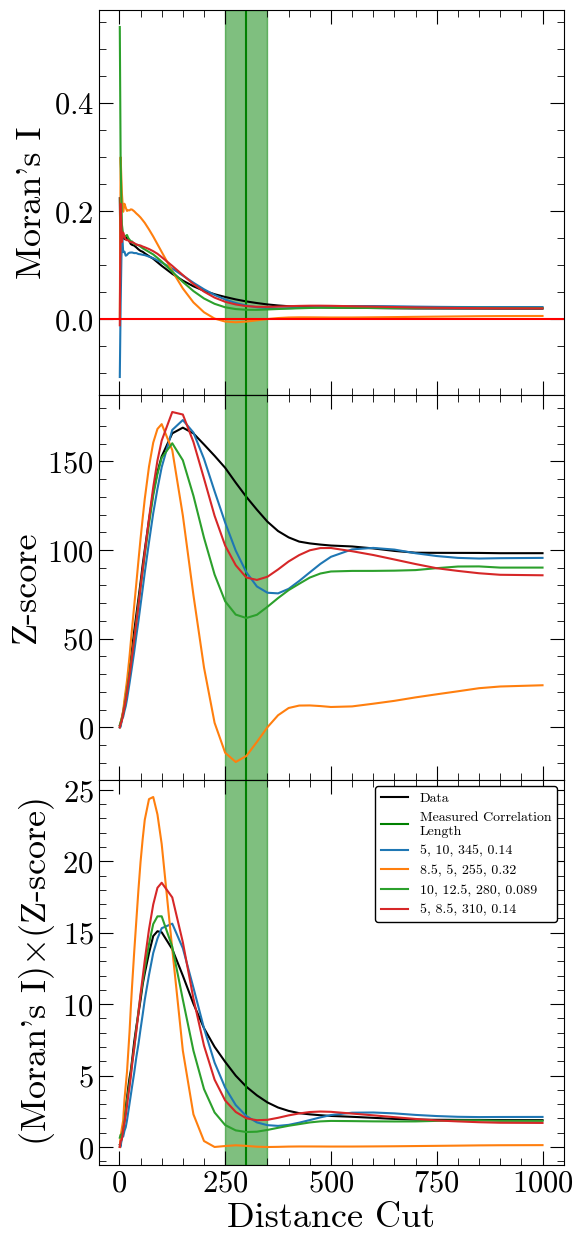

In [238]:
#for the best simulation by each metric, plot against the real data
fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)

#plot real data
ax1.plot(final_distances_real,moransIs_real,color='black',label='Data')
ax2.plot(final_distances_real,zscores_real,color='black',label='Data')
ax3.plot(final_distances_real,mult_real,color='black',label='Data')

ax1.axvline(300,color='green',label='Measured Correlation\nLength')
ax1.axvspan(250,350,color='green',alpha=0.5)
ax2.axvline(300,color='green',label='Measured Correlation\nLength')
ax2.axvspan(250,350,color='green',alpha=0.5)
ax3.axvline(300,color='green',label='Measured Correlation\nLength')
ax3.axvspan(250,350,color='green',alpha=0.5)

cols=['max_abs_diff','min_abs_diff','med_abs_diff','sum_abs_diff']

for col in cols:
    best_sim=comparison[comparison[col] == comparison[col].min()] 
    effect_strength=str(best_sim['effect_strength'].to_list()[0])
    improvement_factor=str(best_sim['improvement_factor'].to_list()[0])
    
    #format
    effect_strength=re.sub(r'\.0$', '', effect_strength)
    improvement_factor=re.sub(r'\.0$', '', improvement_factor)
    
    corr_length=best_sim['corr_length'].to_list()[0]
    epsilon=best_sim['epsilon'].to_list()[0]
    
    #get the data
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output_nb05(corr_length,epsilon,None,None,improvement_factor,effect_strength,None,
                      None,'real_data',plot=False)
    
    #plot the simulation with ULDM
    ax1.plot(final_distances,moransIs,label=str(effect_strength)+', '+str(improvement_factor)+', '+str(corr_length)+', '+str(epsilon))
    ax2.plot(final_distances,zscores,label=str(effect_strength)+', '+str(improvement_factor)+', '+str(corr_length)+', '+str(epsilon))
    ax3.plot(final_distances,mult,label=str(effect_strength)+', '+str(improvement_factor)+', '+str(corr_length)+', '+str(epsilon))


ax1.axhline(expectations[0],color='red',label='No Correlation')
ax1.set_ylabel("Moran's I")
ax3.legend(fontsize=10)
ax2.set_ylabel('Z-score')
ax3.set_xlabel('Distance Cut')
ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")
plt.subplots_adjust(wspace = 0,hspace=0)
plt.show()

# In nb07, we investigate how we can re-create the real signal with distance dependent biases and offsets
Run a bunch of simulations on Rockfish without ULDM

In [239]:
dist_cut_means=[120,140,160]
dist_cut_stds=[5,20,40]
dist_cut2s=[400,500,600]
unc_nears=[1,5,10]
unc_fars=[1,5,10,30]
off_nears=[90,70,50]
off_meds=[0,5,20]
off_fars=[90,70,50]

simulation_params_no_uldm=[]
for unc_near in unc_nears:
    for unc_far in unc_fars:
        for off_near in off_nears:
            for off_med in off_meds:
                for off_far in off_fars:
                    for dist_cut_mean in dist_cut_means:
                        for dist_cut_std in dist_cut_stds:
                            for dist_cut2 in dist_cut2s:
                                sim=[unc_near,unc_far,off_near,off_med,off_far,dist_cut_mean,dist_cut_std,dist_cut2]
                                simulation_params_no_uldm.append(sim)
print(len(simulation_params_no_uldm))   


8748


In [240]:
def get_output_no_uldm(unc_near,unc_far,off_near,off_med,off_far,dist_cut_mean,dist_cut_std,dist_cut2,
                       nonzero_weight_cut=20,plot=True):
    
    #read back in measurements
    npzfile = np.load('csv/nb07_sample_size_10207/'+str(dist_cut_mean)+'_'+str(dist_cut_std)+'_'+str(dist_cut2)+'_'+str(unc_near)+'_'+str(unc_far)+'_'+str(off_near)+'_'+str(off_med)+'_'+str(off_far)+'.npz')   

    Ws = npzfile['Ws']
    final_distances = npzfile['distances']
    moransIs = npzfile['moransIs'] 
    expectations = npzfile['expectations']
    variances = npzfile['variances']
    zscores = npzfile['zscores']
    
    mult=[]
    for i in range(len(moransIs)):
        mult.append(moransIs[i]*zscores[i])
        
    #cut to make sure have enough nonzero weights for valid results
    index = bisect_left(Ws, nonzero_weight_cut)
    
    if plot:
        #plot
        fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)
        ax1.plot(final_distances,moransIs)
        ax1.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax1.axvline(corr_length,color='green',label='True Correlation\nLength')
        ax1.axhline(expectations[0],color='red',label='No Correlation')
        ax1.set_ylabel("Moran's I")
        ax1.legend()

        ax2.plot(final_distances,zscores)
        ax2.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax2.axvline(corr_length,color='green')
        ax2.set_ylabel('Z-score')

        ax3.plot(final_distances,mult)
        ax3.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax3.axvline(corr_length,color='green')
        ax3.set_xlabel('Distance Cut')
        ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")

        plt.subplots_adjust(wspace = 0,hspace=0)
        plt.show()
    
    return(final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index)

In [360]:
simulation_params_not_run_no_uldm=[]
simulation_params_run_no_uldm=[]

#check if each training data simulation has been run
for i in range(len(simulation_params_no_uldm)):
    simulation=simulation_params_no_uldm[i]
    unc_near=simulation[0]
    unc_far=simulation[1]
    off_near=simulation[2]
    off_med=simulation[3]
    off_far=simulation[4]
    dist_cut_mean=simulation[5]
    dist_cut_std=simulation[6]
    dist_cut2=simulation[7]

    try:
        out=get_output_no_uldm(unc_near,unc_far,off_near,off_med,off_far,dist_cut_mean,dist_cut_std,dist_cut2,
                               plot=False)
        simulation_params_run_no_uldm.append(simulation)
    except:
        simulation_params_not_run_no_uldm.append(simulation)
        
print(len(simulation_params_run_no_uldm))
print(len(simulation_params_not_run_no_uldm))

8748
0


In [361]:
sample_size=10207
final_distances_real,med_abs_deviations_real,Ws_real,moransIs_real,expectations_real,variances_real,zscores_real,mult_real,index_real=get_output('csv/nb06_sample_size_10207/data_measurement.npz',nonzero_weight_cut=20,plot=False)

comparison_no_uldm=pd.DataFrame()

unc_nears=[]
unc_fars=[]
off_nears=[]
off_meds=[]
off_fars=[]
dist_cut_means=[]
dist_cut_stds=[]
dist_cut2s=[]
max_abs_diffs=[]
min_abs_diffs=[]
med_abs_diffs=[]
sum_abs_diffs=[]

for i in range(len(simulation_params_run_no_uldm)):
    simulation=simulation_params_run_no_uldm[i]
    
    unc_near=simulation[0]
    unc_far=simulation[1]
    off_near=simulation[2]
    off_med=simulation[3]
    off_far=simulation[4]
    dist_cut_mean=simulation[5]
    dist_cut_std=simulation[6]
    dist_cut2=simulation[7]

    unc_nears.append(unc_near)
    unc_fars.append(unc_far)
    off_nears.append(off_near)
    off_meds.append(off_med)
    off_fars.append(off_far)
    dist_cut_means.append(dist_cut_mean)
    dist_cut_stds.append(dist_cut_std)
    dist_cut2s.append(dist_cut2)


    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output_no_uldm(unc_near,unc_far,off_near,off_med,off_far,dist_cut_mean,dist_cut_std,dist_cut2,
                                                                                                                plot=False)

    #get the difference between the simulation and the real data
    #exclude the data points for separations<10 since these can be very noisy
    differences=np.array(mult_real[4:])-np.array(mult[4:])
    abs_diff=np.abs(differences)

    max_abs_diffs.append(max(abs_diff))
    min_abs_diffs.append(min(abs_diff))
    med_abs_diffs.append(np.median(abs_diff))
    sum_abs_diffs.append(np.sum(abs_diff))
    
comparison_no_uldm['unc_near']=unc_nears
comparison_no_uldm['unc_far']=unc_fars
comparison_no_uldm['off_near']=off_nears
comparison_no_uldm['off_med']=off_meds
comparison_no_uldm['off_far']=off_fars
comparison_no_uldm['dist_cut_mean']=dist_cut_means
comparison_no_uldm['dist_cut_std']=dist_cut_stds
comparison_no_uldm['dist_cut2']=dist_cut2s
comparison_no_uldm['max_abs_diff']=max_abs_diffs
comparison_no_uldm['min_abs_diff']=min_abs_diffs
comparison_no_uldm['med_abs_diff']=med_abs_diffs
comparison_no_uldm['sum_abs_diff']=sum_abs_diffs

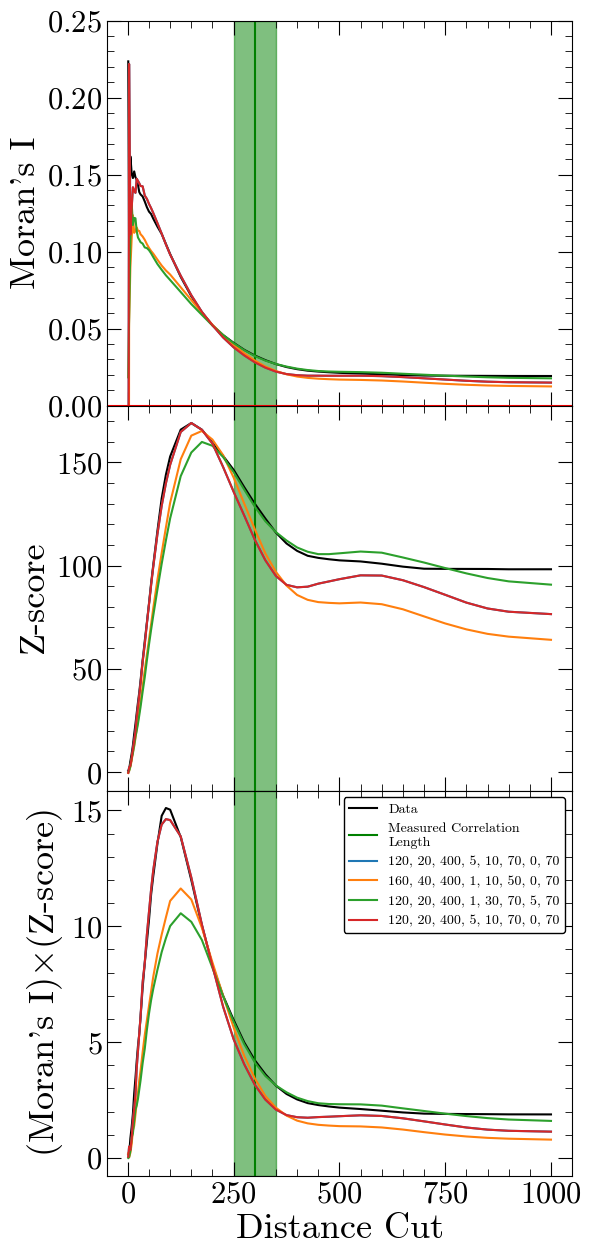

In [362]:
#for the best simulation by each metric, plot against the real data
fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)

#plot real data
ax1.plot(final_distances_real,moransIs_real,color='black',label='Data')
ax2.plot(final_distances_real,zscores_real,color='black',label='Data')
ax3.plot(final_distances_real,mult_real,color='black',label='Data')

ax1.axvline(300,color='green',label='Measured Correlation\nLength')
ax1.axvspan(250,350,color='green',alpha=0.5)
ax2.axvline(300,color='green',label='Measured Correlation\nLength')
ax2.axvspan(250,350,color='green',alpha=0.5)
ax3.axvline(300,color='green',label='Measured Correlation\nLength')
ax3.axvspan(250,350,color='green',alpha=0.5)

cols=['max_abs_diff', 'min_abs_diff', 'med_abs_diff', 'sum_abs_diff']

for col in cols:
    best_sim=comparison_no_uldm[comparison_no_uldm[col] == comparison_no_uldm[col].min()] 
    unc_near=int(best_sim['unc_near'].to_list()[0])
    unc_far=int(best_sim['unc_far'].to_list()[0])
    off_near=int(best_sim['off_near'].to_list()[0])
    off_med=int(best_sim['off_med'].to_list()[0])
    off_far=int(best_sim['off_far'].to_list()[0])
    dist_cut_mean=int(best_sim['dist_cut_mean'].to_list()[0])
    dist_cut_std=int(best_sim['dist_cut_std'].to_list()[0])
    dist_cut2=int(best_sim['dist_cut2'].to_list()[0])

    #get the data
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output_no_uldm(unc_near,unc_far,off_near,off_med,off_far,dist_cut_mean,dist_cut_std,dist_cut2,
                                                                                                                plot=False)
    
    #plot the simulation with ULDM
    ax1.plot(final_distances,moransIs,label=str(dist_cut_mean)+', '+str(dist_cut_std)+', '+str(dist_cut2)+', '+str(unc_near)+', '+str(unc_far)+', '+str(off_near)+', '+str(off_med)+', '+str(off_far))
    ax2.plot(final_distances,zscores,label=str(dist_cut_mean)+', '+str(dist_cut_std)+', '+str(dist_cut2)+', '+str(unc_near)+', '+str(unc_far)+', '+str(off_near)+', '+str(off_med)+', '+str(off_far))
    ax3.plot(final_distances,mult,label=str(dist_cut_mean)+', '+str(dist_cut_std)+', '+str(dist_cut2)+', '+str(unc_near)+', '+str(unc_far)+', '+str(off_near)+', '+str(off_med)+', '+str(off_far))


ax1.axhline(expectations[0],color='red',label='No Correlation')
ax1.set_ylabel("Moran's I")
ax3.legend(fontsize=10)
ax2.set_ylabel('Z-score')
ax3.set_xlabel('Distance Cut')
ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")
plt.subplots_adjust(wspace = 0,hspace=0)

ax1.set_ylim(0,0.25)
plt.show()

# Final plot: overlay extinction-corrected curve from real data, best matching ULDM simulation with same corr length as measured, and best matching simulation with curve shape created by non-DM effects

In [14]:
#get average z-score for WDs separated by <coherence length of 300 pc
sample_size=10207
final_distances_real,med_abs_deviations_real,Ws_real,moransIs_real,expectations_real,variances_real,zscores_real,mult_real,index_real=get_output('csv/nb06_sample_size_10207/data_measurement.npz',nonzero_weight_cut=20,plot=False)
get_avg_df=pd.DataFrame({'sep':final_distances_real,'zscore':zscores_real})
print(get_avg_df.query('sep<=300')['zscore'].mean())

84.56412750569235


Best sim with ULDM


,effect_strength,improvement_factor,corr_length,epsilon,max_abs_diff,min_abs_diff,med_abs_diff,sum_abs_diff
1789,5.0,10.0,345,0.14,2.165346,0.004075,1.236095,48.159103


Best sim without ULDM


,unc_near,unc_far,off_near,off_med,off_far,dist_cut_mean,dist_cut_std,dist_cut2,max_abs_diff,min_abs_diff,med_abs_diff,sum_abs_diff
4647,5,10,70,0,70,120,20,400,1.094498,0.021668,0.373894,18.632969


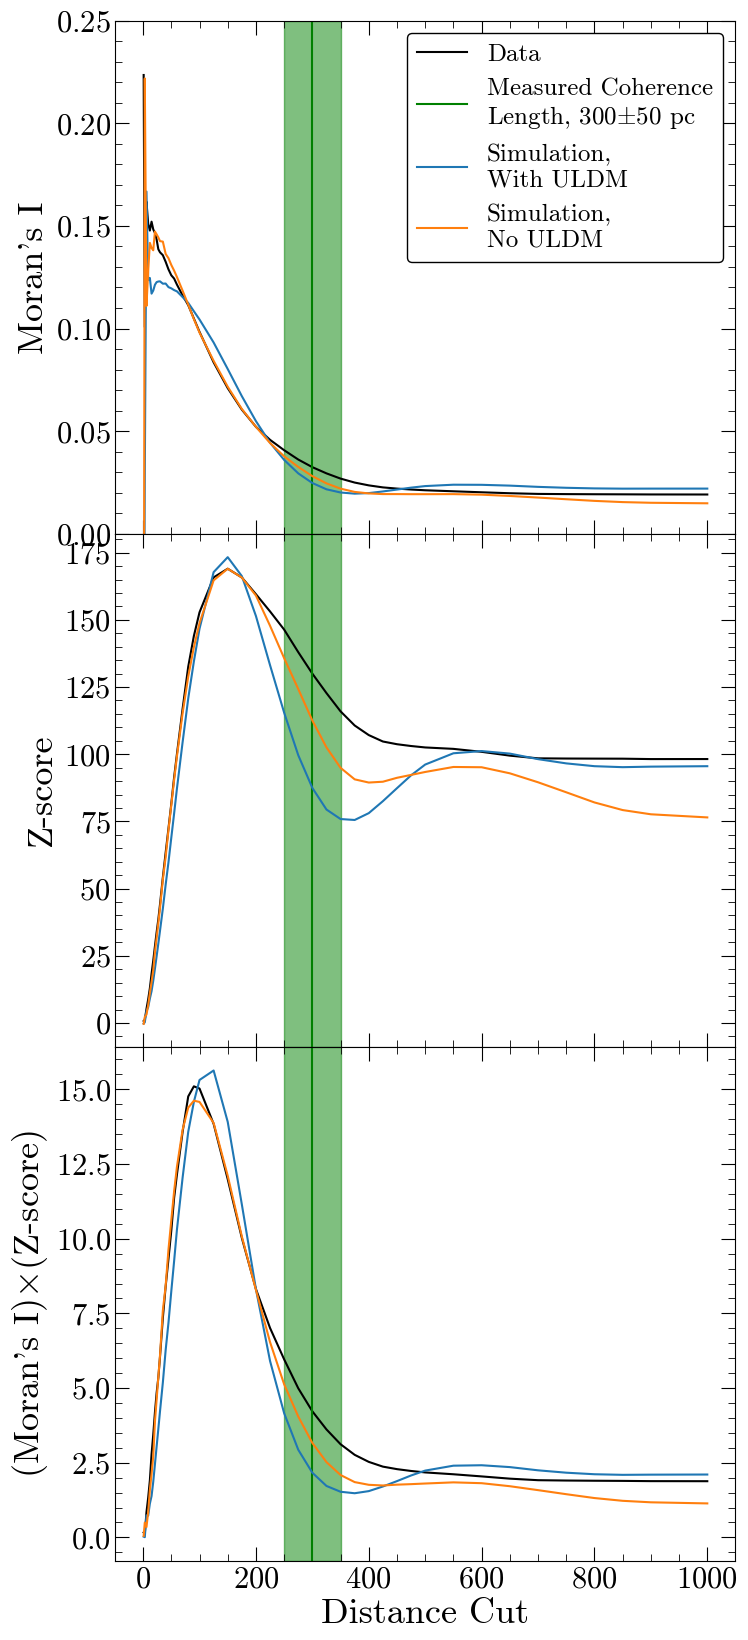

In [363]:
#for the best simulation by each metric, plot against the real data
fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(8,20),sharex=True)

#plot real data
ax1.plot(final_distances_real,moransIs_real,color='black',label='Data')
ax2.plot(final_distances_real,zscores_real,color='black',label='Data')
ax3.plot(final_distances_real,mult_real,color='black',label='Data')

ax1.axvline(300,color='green',label='Measured Coherence\nLength, 300$\mathrm{\pm}$50 pc')
ax1.axvspan(250,350,color='green',alpha=0.5)
ax2.axvline(300,color='green',label='Measured Coherence\nLength, 300$\mathrm{\pm}$50 pc')
ax2.axvspan(250,350,color='green',alpha=0.5)
ax3.axvline(300,color='green',label='Measured Coherence\nLength, 300$\mathrm{\pm}$50 pc')
ax3.axvspan(250,350,color='green',alpha=0.5)

#plot the best fitting curve with ULDM
col='max_abs_diff'
best_sim=comparison[comparison[col] == comparison[col].min()] 
print('Best sim with ULDM')
display(best_sim)
effect_strength=str(best_sim['effect_strength'].to_list()[0])
improvement_factor=str(best_sim['improvement_factor'].to_list()[0])
effect_strength=re.sub(r'\.0$', '', effect_strength)
improvement_factor=re.sub(r'\.0$', '', improvement_factor)
corr_length=best_sim['corr_length'].to_list()[0]
epsilon=best_sim['epsilon'].to_list()[0]
final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output_nb05(corr_length,epsilon,None,None,improvement_factor,effect_strength,None,
                  None,'real_data',plot=False)
ax1.plot(final_distances,moransIs,label='Simulation,\nWith ULDM')
ax2.plot(final_distances,zscores,label='Simulation,\nWith ULDM')
ax3.plot(final_distances,mult,label='Simulation,\nWith ULDM')


#plot the best fitting curve without ULDM
col='max_abs_diff'
best_sim=comparison_no_uldm[comparison_no_uldm[col] == comparison_no_uldm[col].min()] 
print('Best sim without ULDM')
display(best_sim)
unc_near=int(best_sim['unc_near'].to_list()[0])
unc_far=int(best_sim['unc_far'].to_list()[0])
off_near=int(best_sim['off_near'].to_list()[0])
off_med=int(best_sim['off_med'].to_list()[0])
off_far=int(best_sim['off_far'].to_list()[0])
dist_cut_mean=int(best_sim['dist_cut_mean'].to_list()[0])
dist_cut_std=int(best_sim['dist_cut_std'].to_list()[0])
dist_cut2=int(best_sim['dist_cut2'].to_list()[0])
final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output_no_uldm(unc_near,unc_far,off_near,off_med,off_far,dist_cut_mean,dist_cut_std,dist_cut2,
                                                                                                            plot=False)

ax1.plot(final_distances,moransIs,label='Simulation,\nNo ULDM')
ax2.plot(final_distances,zscores,label='Simulation,\nNo ULDM')
ax3.plot(final_distances,mult,label='Simulation,\nNo ULDM')

ax1.set_ylabel("Moran's I")
ax1.legend()
ax2.set_ylabel('Z-score')
ax3.set_xlabel('Distance Cut')
ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")
plt.subplots_adjust(wspace = 0,hspace=0)

ax1.set_ylim(0,0.25)

plt.savefig('curves_real_data.pdf', dpi=300)

# Test whether the signal in the real data could be caused by distance-dependent observation biases
- Investigate how signal changes with cuts on distance, temperature, radius, logg, and mass


- To test whether this could be caused by cool/massive WDs, re-measure the signal implementing temperature/mass cuts to see if it is robust against that.
- Scale height cutoff is 300 pc so can get different populations of WDs beyond this, try with 300pc distance cut

In [264]:
def obs_bias_test(parameter):
    sample_size=len(reformat_wdtable)
    #distance cut array
    distances=np.array([1,3,6,9,12,15,18,21,24,27,30,35,40,45,50,55,60,70,80,90,100,125,150,175,200,225,250,275,300,325,350,375,400,
                        425,450,475,500,550,600,650,700,750,800,850,900,1000])
    
    # Compute quantiles
    q1 = reformat_wdtable[parameter].quantile(1/3)
    q2 = reformat_wdtable[parameter].quantile(2/3)
    
    print(q1,q2)

    # Create masks
    low_mask = reformat_wdtable[parameter] <= q1
    mid_mask = (reformat_wdtable[parameter] > q1) & (reformat_wdtable[parameter] <= q2)
    high_mask = reformat_wdtable[parameter] > q2

    # Create the subsets of low, medium, and high values for that parameter
    low = reformat_wdtable[low_mask]
    indices=np.arange(0,len(low))
    low.set_index(indices,inplace=True)
    
    mid = reformat_wdtable[mid_mask]
    indices=np.arange(0,len(mid))
    mid.set_index(indices,inplace=True)
    
    high = reformat_wdtable[high_mask]
    indices=np.arange(0,len(high))
    high.set_index(indices,inplace=True)
    
    #path to save outputs
    final_path='csv/nb06_sample_size_'+str(sample_size)
    #make directory if does not exist
    try:
        os.makedirs(final_path)
    except:
        pass
    
    tables=[low,mid,high]
    table_names=['low','mid','high']
    for i in range(len(tables)):
        table=tables[i]
        table_name=table_names[i]
        #check if have already run this configuration
        try:
            npzfile = np.load(final_path+'/'+parameter+'_'+table_name+'.npz')
        except:
            path,num_dfs_ijsum,med_abs_deviation=MoransI_contributions(table,sample_size,max_len=100000)

            #calculate Moran's I for range of distances 
            Ws,moransIs,expectations, variances,zscores=MoransI_calculation(path,num_dfs_ijsum,distances)

            #write the data in a txt file
            np.savez(final_path+'/'+parameter+'_'+table_name,Ws=Ws,med_abs_deviations=med_abs_deviation, distances=distances,moransIs=moransIs,expectations=expectations,variances=variances,zscores=zscores)  

            #delete the intermediate files
            shutil.rmtree(path)
            

In [265]:
#run for distance
obs_bias_test('distance_measured')

182.25761 317.724884033203


100%|███████████████████████████████████████| 3403/3403 [02:54<00:00, 19.52it/s]


In [266]:
#run for temperature
obs_bias_test('teff_measured')

10873.297539628971 17311.101417087895


100%|███████████████████████████████████████| 3403/3403 [02:55<00:00, 19.38it/s]


In [267]:
#run for radius
obs_bias_test('radius_measured')

0.0123896215378101 0.013880270168220899


100%|███████████████████████████████████████| 3403/3403 [02:52<00:00, 19.77it/s]


In [268]:
#run for logg
obs_bias_test('logg_measured')

7.896719999999999 8.03536


100%|███████████████████████████████████████| 3402/3402 [02:53<00:00, 19.62it/s]


In [269]:
#run for mass 
obs_bias_test('mass_measured')

0.4980895291706312 0.6840886280979469


100%|███████████████████████████████████████| 3403/3403 [02:54<00:00, 19.53it/s]


(0.0, 0.5)

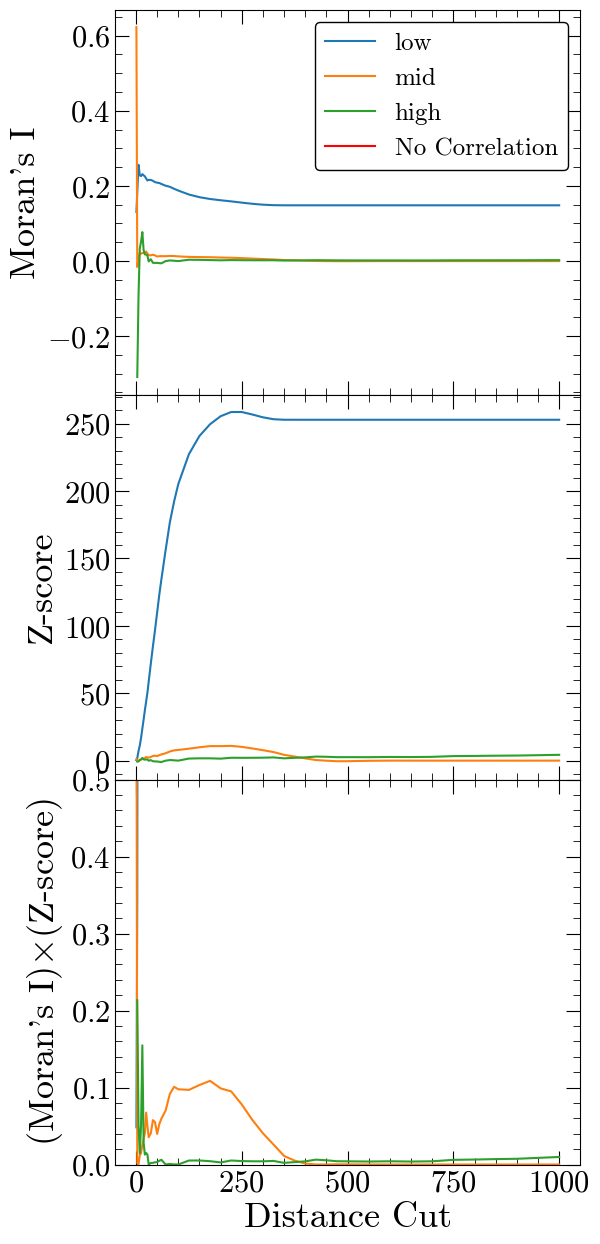

In [318]:
#plot the Moran's I curve for different distance cuts
parameter='distance_measured'

sample_size=len(reformat_wdtable)

fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)

table_names=['low','mid','high']
for table_name in table_names:
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output('csv/nb06_sample_size_'+str(sample_size)+'/'+parameter+'_'+table_name+'.npz',plot=False)
    ax1.plot(final_distances,moransIs,label=table_name)
    ax2.plot(final_distances,zscores,label=table_name)
    ax3.plot(final_distances,mult,label=table_name)

ax1.axhline(expectations[0],color='red',label='No Correlation')
ax1.set_ylabel("Moran's I")
ax1.legend()
ax2.set_ylabel('Z-score')
ax3.set_xlabel('Distance Cut')
ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")
plt.subplots_adjust(wspace = 0,hspace=0)

ax3.set_ylim(0,0.5)

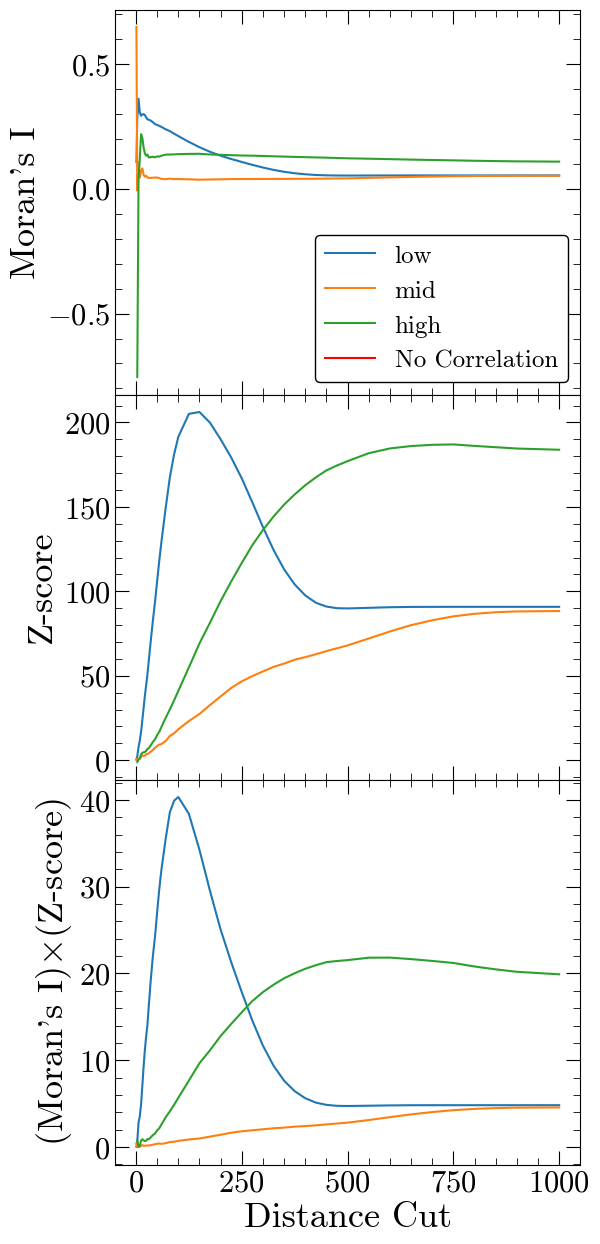

In [271]:
#plot the Moran's I curve for different teff cuts
parameter='teff_measured'

sample_size=len(reformat_wdtable)

fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)

table_names=['low','mid','high']
for table_name in table_names:
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output('csv/nb06_sample_size_'+str(sample_size)+'/'+parameter+'_'+table_name+'.npz',plot=False)
    ax1.plot(final_distances,moransIs,label=table_name)
    ax2.plot(final_distances,zscores,label=table_name)
    ax3.plot(final_distances,mult,label=table_name)

ax1.axhline(expectations[0],color='red',label='No Correlation')
ax1.set_ylabel("Moran's I")
ax1.legend()
ax2.set_ylabel('Z-score')
ax3.set_xlabel('Distance Cut')
ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")
plt.subplots_adjust(wspace = 0,hspace=0)



(0.0, 10.0)

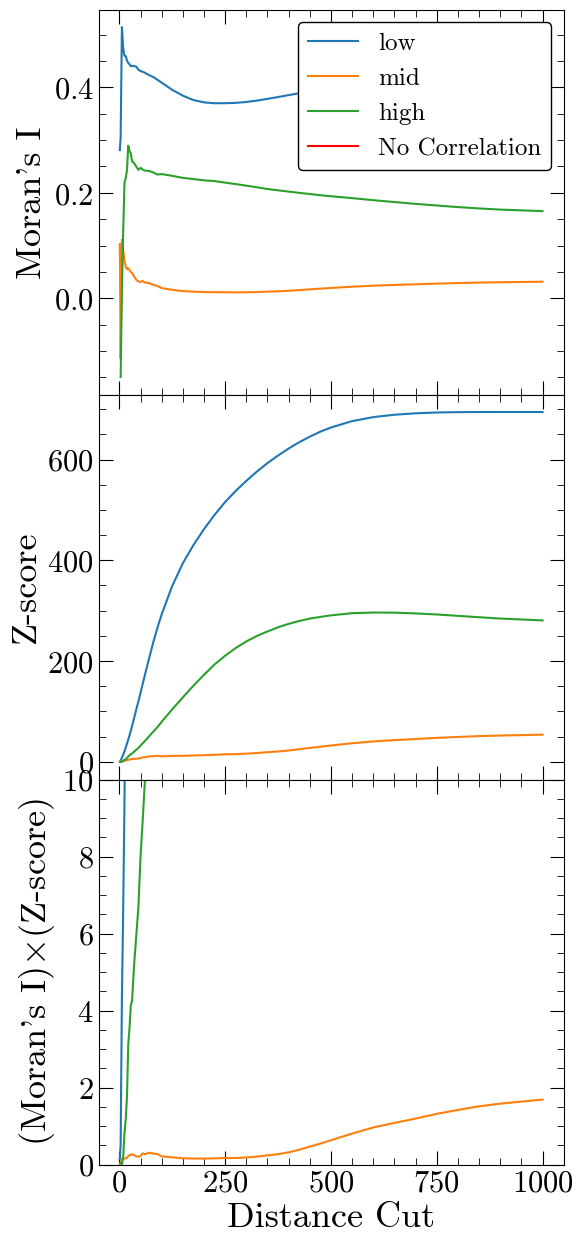

In [278]:
#plot the Moran's I curve for different radius cuts
parameter='radius_measured'

sample_size=len(reformat_wdtable)

fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)

table_names=['low','mid','high']
for table_name in table_names:
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output('csv/nb06_sample_size_'+str(sample_size)+'/'+parameter+'_'+table_name+'.npz',plot=False)
    ax1.plot(final_distances,moransIs,label=table_name)
    ax2.plot(final_distances,zscores,label=table_name)
    ax3.plot(final_distances,mult,label=table_name)

ax1.axhline(expectations[0],color='red',label='No Correlation')
ax1.set_ylabel("Moran's I")
ax1.legend()
ax2.set_ylabel('Z-score')
ax3.set_xlabel('Distance Cut')
ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")
plt.subplots_adjust(wspace = 0,hspace=0)

ax3.set_ylim(0,10)

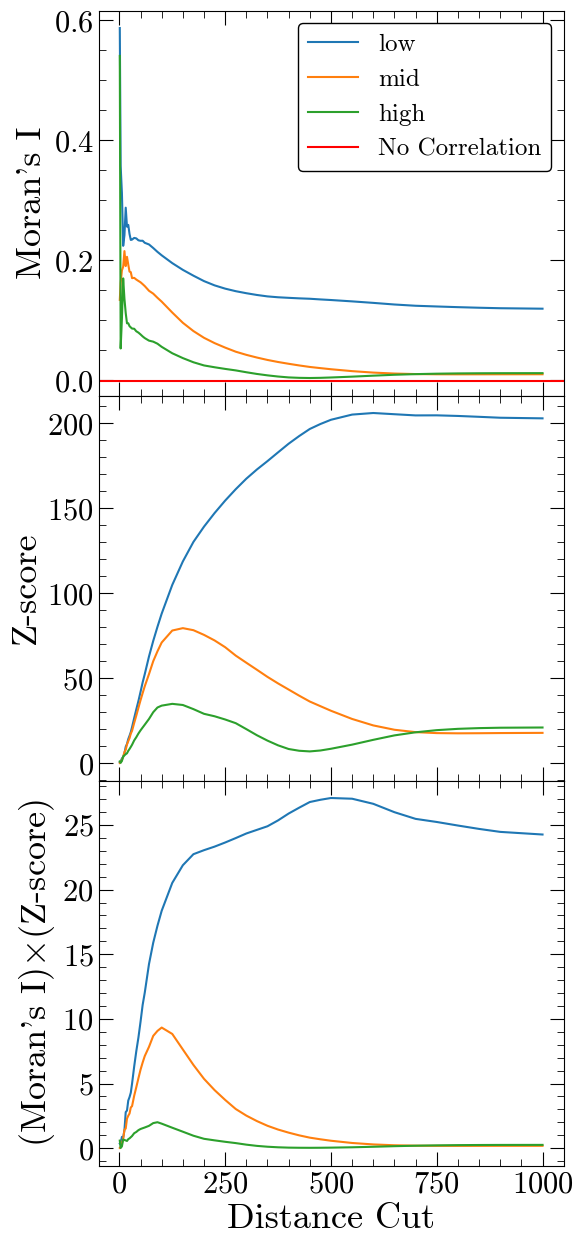

In [273]:
#plot the Moran's I curve for different logg cuts
parameter='logg_measured'

sample_size=len(reformat_wdtable)

fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)

table_names=['low','mid','high']
for table_name in table_names:
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output('csv/nb06_sample_size_'+str(sample_size)+'/'+parameter+'_'+table_name+'.npz',plot=False)
    ax1.plot(final_distances,moransIs,label=table_name)
    ax2.plot(final_distances,zscores,label=table_name)
    ax3.plot(final_distances,mult,label=table_name)

ax1.axhline(expectations[0],color='red',label='No Correlation')
ax1.set_ylabel("Moran's I")
ax1.legend()
ax2.set_ylabel('Z-score')
ax3.set_xlabel('Distance Cut')
ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")
plt.subplots_adjust(wspace = 0,hspace=0)


(0.0, 10.0)

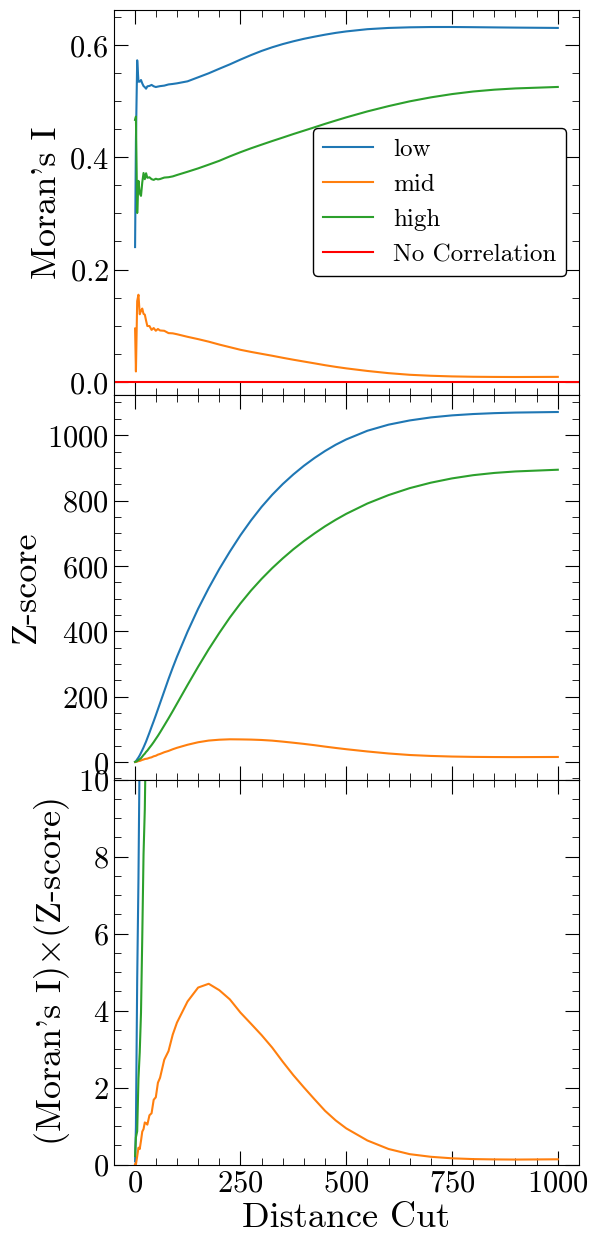

In [279]:
#plot the Moran's I curve for different mass cuts
parameter='mass_measured'

sample_size=len(reformat_wdtable)

fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)

table_names=['low','mid','high']
for table_name in table_names:
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output('csv/nb06_sample_size_'+str(sample_size)+'/'+parameter+'_'+table_name+'.npz',plot=False)
    ax1.plot(final_distances,moransIs,label=table_name)
    ax2.plot(final_distances,zscores,label=table_name)
    ax3.plot(final_distances,mult,label=table_name)

ax1.axhline(expectations[0],color='red',label='No Correlation')
ax1.set_ylabel("Moran's I")
ax1.legend()
ax2.set_ylabel('Z-score')
ax3.set_xlabel('Distance Cut')
ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")
plt.subplots_adjust(wspace = 0,hspace=0)

ax3.set_ylim(0,10)

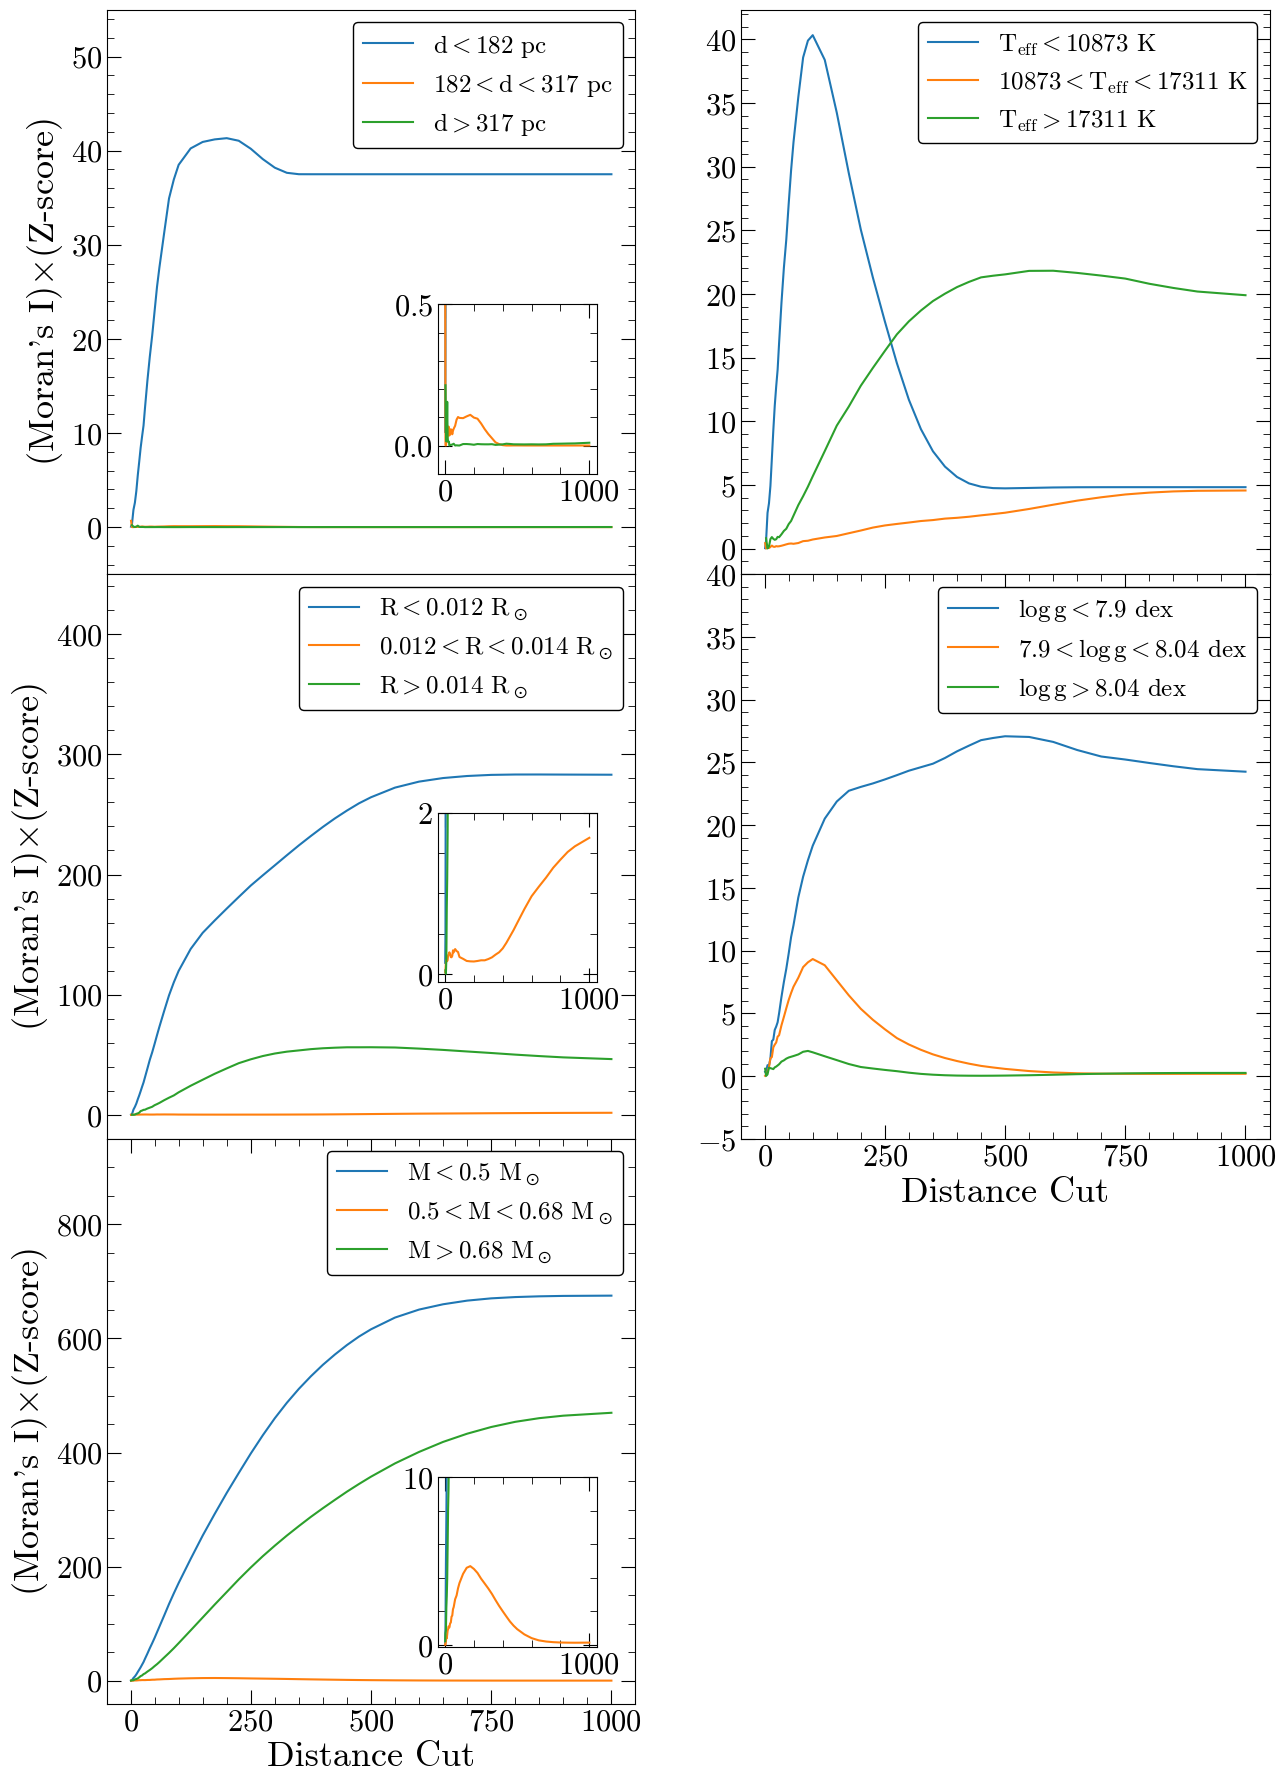

In [355]:
#combine all of these together into one plot
sample_size=len(reformat_wdtable)
table_names=['low','mid','high']

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(15,22))

#plot the Moran's I curve for different distance cuts
parameter='distance_measured'
q1 = int(reformat_wdtable[parameter].quantile(1/3))
q2 = int(reformat_wdtable[parameter].quantile(2/3))
labels=['$d\mathrm{<}$'+str(q1)+' pc',str(q1)+'$\mathrm{<}d\mathrm{<}$'+str(q2)+' pc','$d\mathrm{>}$'+str(q2)+' pc']
# Create inset
axins1 = inset_axes(ax1,width="100%", height="100%",
                    bbox_to_anchor=(0.65, 0.2, 0.3, 0.3),
                    bbox_transform=ax1.transAxes)
for i in range(len(table_names)):
    table_name=table_names[i]
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output('csv/nb06_sample_size_'+str(sample_size)+'/'+parameter+'_'+table_name+'.npz',plot=False)
    ax1.plot(final_distances,mult,label=labels[i])
    axins1.plot(final_distances,mult)
# Limit the region shown in the inset
axins1.set_xlim(ax1.get_xlim())
axins1.set_ylim(-0.1, 0.5)
    
#plot the Moran's I curve for different temperature cuts
parameter='teff_measured'
q1 = int(reformat_wdtable[parameter].quantile(1/3))
q2 = int(reformat_wdtable[parameter].quantile(2/3))
labels=['$T_{eff}\mathrm{<}$'+str(q1)+' K',str(q1)+'$\mathrm{<}T_{eff}\mathrm{<}$'+str(q2)+' K','$T_{eff}\mathrm{>}$'+str(q2)+' K']
for i in range(len(table_names)):
    table_name=table_names[i]
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output('csv/nb06_sample_size_'+str(sample_size)+'/'+parameter+'_'+table_name+'.npz',plot=False)
    ax2.plot(final_distances,mult,label=labels[i])
    
#plot the Moran's I curve for different radius cuts
parameter='radius_measured'
q1 = np.round(reformat_wdtable[parameter].quantile(1/3),3)
q2 = np.round(reformat_wdtable[parameter].quantile(2/3),3)
labels=['$R\mathrm{<}$'+str(q1)+' $R_\odot$',str(q1)+'$\mathrm{<}R\mathrm{<}$'+str(q2)+' $R_\odot$','$R\mathrm{>}$'+str(q2)+' $R_\odot$']
# Create inset
axins3 = inset_axes(ax3,width="100%", height="100%",
                    bbox_to_anchor=(0.65, 0.3, 0.3, 0.3),
                    bbox_transform=ax3.transAxes)
for i in range(len(table_names)):
    table_name=table_names[i]
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output('csv/nb06_sample_size_'+str(sample_size)+'/'+parameter+'_'+table_name+'.npz',plot=False)
    ax3.plot(final_distances,mult,label=labels[i])
    axins3.plot(final_distances,mult)
# Limit the region shown in the inset
axins3.set_xlim(ax3.get_xlim())
axins3.set_ylim(-0.1, 2)

#plot the Moran's I curve for different logg cuts
parameter='logg_measured'
q1 = np.round(reformat_wdtable[parameter].quantile(1/3),2)
q2 = np.round(reformat_wdtable[parameter].quantile(2/3),2)
labels=['$\log{g}\mathrm{<}$'+str(q1)+' dex',str(q1)+'$\mathrm{<}\log{g}\mathrm{<}$'+str(q2)+' dex','$\log{g}\mathrm{>}$'+str(q2)+' dex']
for i in range(len(table_names)):
    table_name=table_names[i]
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output('csv/nb06_sample_size_'+str(sample_size)+'/'+parameter+'_'+table_name+'.npz',plot=False)
    ax4.plot(final_distances,mult,label=labels[i])

#plot the Moran's I curve for different mass cuts
parameter='mass_measured'
q1 = np.round(reformat_wdtable[parameter].quantile(1/3),2)
q2 = np.round(reformat_wdtable[parameter].quantile(2/3),2)
labels=['$M\mathrm{<}$'+str(q1)+' $M_\odot$',str(q1)+'$\mathrm{<}M\mathrm{<}$'+str(q2)+' $M_\odot$','$M\mathrm{>}$'+str(q2)+' $M_\odot$']
# Create inset
axins5 = inset_axes(ax5,width="100%", height="100%",
                    bbox_to_anchor=(0.65, 0.123, 0.3, 0.3),
                    bbox_transform=ax5.transAxes)
for i in range(len(table_names)):
    table_name=table_names[i]
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output('csv/nb06_sample_size_'+str(sample_size)+'/'+parameter+'_'+table_name+'.npz',plot=False)
    ax5.plot(final_distances,mult,label=labels[i])
    axins5.plot(final_distances,mult)
# Limit the region shown in the inset
axins5.set_xlim(ax5.get_xlim())
axins5.set_ylim(-0.1, 10)

ax6.set_axis_off()

ax1.set_ylabel(r"(Moran's I)$\times$(Z-score)")
ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")
ax5.set_ylabel(r"(Moran's I)$\times$(Z-score)")

ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])
ax4.set_xlabel('Distance Cut')
ax5.set_xlabel('Distance Cut')

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')
ax5.legend(loc='upper right')

ax1.set_ylim(-5,55)
ax3.set_ylim(-20,450)
ax4.set_ylim(-5,40)
ax5.set_ylim(-40,950)

plt.subplots_adjust(hspace=0)

plt.savefig('curves_bin_params.pdf', dpi=300)
